In [1]:
import torch
import torch.nn as nn
import torch.utils.data as Data
import torchvision
from torch.nn import functional as F
from torch.autograd import Variable
from sklearn.linear_model import LinearRegression

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
import numpy as np
import h5py
import cv2
from scipy.stats import pearsonr
import datetime
import time
import itertools
import pickle

from VariationalNC.utils import *
from VariationalNC.train import *
from VariationalNC.Variational_layers import VariationalLinear, VariationalConv2d
from VariationalNC.Variational_utils import variational_estimator, ScaleMixtureGaussian

# for auto-reloading external modules
%load_ext autoreload
%autoreload 2

# for plot figures
#Output matplotlib figure to SVG with text as text, not curves
plt.rcParams['svg.fonttype'] = 'none'

In [2]:
torch.backends.cudnn.benchmark = False
torch.cuda.manual_seed(1)

torch.backends.cudnn.deterministic=True
np.random.seed(1)
torch.manual_seed(1)    # reproducible

In [3]:
#load data
with open('Data_Franke_et_al_2021/static25311-10-26.pkl', 'rb') as f:
    loaded_dict = pickle.load(f)
print (loaded_dict.keys())

dict_keys(['training_inputs', 'training_responses', 'test_inputs', 'test_responses_repeats'])


## Prepare data for modeling

training inputs shape: (4409, 2, 36, 64)
Max: 255.0


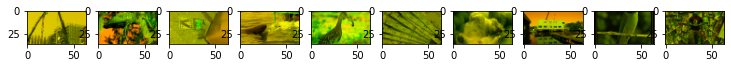

In [10]:
#training data, shape (4409, 2, 36, 64), number of stimuli: 4409, stimuli size: (2, 36, 64)
#the maximum is 255
training_inputs = loaded_dict['training_inputs'] 
#Rescaling，make the data range 0-1.0
#training_inputs=training_inputs/255.0
print ('training inputs shape: {}'.format(training_inputs.shape))
print ('Max: {}'.format(np.max(training_inputs)))
fig, axes = plt.subplots(nrows=1, ncols=10,figsize=(12.5,2.5))
for ii in range(10):
    temp = training_inputs[ii]
    temp2 = np.zeros((temp.shape[1],temp.shape[2],3), dtype=np.uint8)
    temp2[:,:,:2] = np.transpose(temp,(1,2,0))[:,:,::-1]
    axes[ii].imshow(temp2)

training responses shape: (4409, 161)


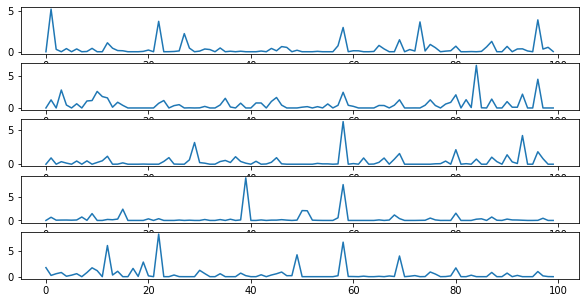

In [11]:
#training responses, shape (4409, 161),number of stimuli: 4409, number of neurons: 161
training_set = loaded_dict['training_responses'] 
#get sqrt of response
#reference: the effects of a square root transform on a Poisson distriuted quantity. (Thacker, 2001)
print ('training responses shape: {}'.format(training_set.shape))
fig, axes = plt.subplots(nrows=5, ncols=1,figsize=(10,5))
for ii in range(5):
    axes[ii].plot(training_set[:100,ii])

test inputs shape: (79, 2, 36, 64)
Max: 255.0


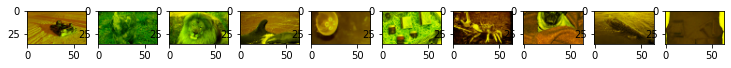

In [12]:
#test data, shape (79, 2, 36, 64), number of stimuli: 79, stimuli size: (2, 36, 64)
test_inputs = loaded_dict['test_inputs'] 
#make the data range 0-1.0
#test_inputs=test_inputs/255.0
print ('test inputs shape: {}'.format(test_inputs.shape))
print ('Max: {}'.format(np.max(test_inputs)))
fig, axes = plt.subplots(nrows=1, ncols=10,figsize=(12.5,2.5))
for ii in range(10):
    temp = test_inputs[ii]
    temp2 = np.zeros((temp.shape[1],temp.shape[2],3), dtype=np.uint8)
    temp2[:,:,:2] = np.transpose(temp,(1,2,0))[:,:,::-1]
    axes[ii].imshow(temp2)

test responses shape: (79, 161)


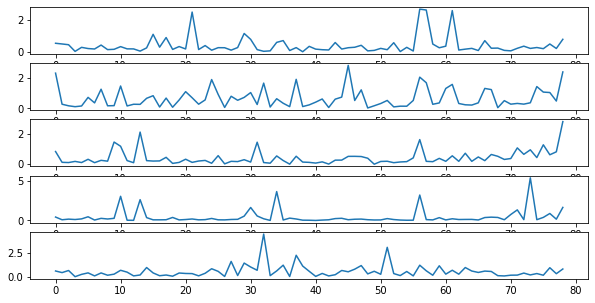

In [13]:
#test data, shape (79, 161), number of stimuli: 79, number of neurons: 161
#test_responses_repeats, shape (79,10,529), 10 repeats
test_set = np.mean(loaded_dict['test_responses_repeats'], axis=1) 
#get sqrt of response
#reference: the effects of a square root transform on a Poisson distriuted quantity. (Thacker, 2001)
print ('test responses shape: {}'.format(test_set.shape))
fig, axes = plt.subplots(nrows=5, ncols=1,figsize=(10,5))
for ii in range(5):
    axes[ii].plot(test_set[:,ii])

In [15]:
#split original training data into two parts, training loader: 4000, validation loader: 400
train_num, valid_num = 4000, 400
batch_size = 400 # 200
train_mean=np.mean(training_inputs[:train_num], axis=(0,2,3), keepdims=True)/255.0
print (train_mean.shape, train_mean)
#make the dataset suitable for pytorch
train_loader=[]
for ii in range(0,train_num, batch_size):
    temp0=training_inputs[ii:ii+batch_size]/255.0 - train_mean
    #temp0=np.reshape(temp0,(800,31,31))
    #temp0=np.expand_dims(temp0,axis=1)
    temp1=training_set[ii:ii+batch_size] 
    temp=(temp0,temp1)
    train_loader.append(temp)

temp0=training_inputs[train_num : train_num+valid_num]/255.0 - train_mean
#temp0=np.reshape(temp0,(200,31,31))
#temp0=np.expand_dims(temp0,axis=1)
temp1=training_set[train_num : train_num+valid_num] #200*103(neurons)
val_loader=(temp0,temp1)

temp0=np.copy(test_inputs)/255.0 - train_mean
#temp0=np.reshape(temp0,(50,31,31))
#temp0=np.expand_dims(temp0,axis=1)
temp1=np.copy(test_set) #50*103(neurons)
test_loader=(temp0,temp1)

print ('length of train_loader:')
print (len(train_loader))
print ('shape of train_loader[0][0]:')
print (train_loader[0][0].shape)
print ('shape of train_loader[0][1]:')
print (train_loader[0][1].shape)
print ('shape of val_loader[0]:')
print (val_loader[0].shape)
print ('shape of val_loader[1]:')
print (val_loader[1].shape)
print ('shape of test_loader[0]:')
print (test_loader[0].shape)
print ('shape of test_loader[1]:')
print (test_loader[1].shape)

(1, 2, 1, 1) [[[[0.48079547]]

  [[0.47780535]]]]
length of train_loader:
10
shape of train_loader[0][0]:
(400, 2, 36, 64)
shape of train_loader[0][1]:
(400, 161)
shape of val_loader[0]:
(400, 2, 36, 64)
shape of val_loader[1]:
(400, 161)
shape of test_loader[0]:
(79, 2, 36, 64)
shape of test_loader[1]:
(79, 161)


In [17]:
device=torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device_cpu=torch.device('cpu')
#device=torch.device('cpu')
EPOCH = 50
LR=0.0001
L2=0.0
TEST_SAMPLES = 10

## Models

In [18]:
#
class VanillaCNN(nn.Module):
    def __init__(self,numoffea=48):
        super().__init__()
        self.numoffea=numoffea #number of features
        self.sizeoffea=22*50 #size of feature
        self.numofneuron=test_loader[1].shape[1] #number of neurons
        #
        self.conv1 = nn.Conv2d(2,48,kernel_size=9,stride=1)#24,23*23
        stdv = 1. / np.sqrt(1*9*9)
        self.conv1.weight.data.uniform_(-stdv, stdv)
        self.conv1.bias.data.uniform_(-stdv, stdv)
        #
        self.conv2=nn.Conv2d(48,self.numoffea,kernel_size=7,stride=1)#48,17*17
        stdv = 1. / np.sqrt(48*7*7)
        self.conv2.weight.data.uniform_(-stdv, stdv)
        self.conv2.bias.data.uniform_(-stdv, stdv)
        #
        self.fc1 = nn.Linear(self.numoffea*self.sizeoffea, self.numofneuron)
        stdv = 1. / np.sqrt(self.numoffea*self.sizeoffea)
        self.fc1.weight.data.uniform_(-stdv, stdv)
        self.fc1.bias.data.uniform_(-stdv, stdv)
    def forward(self, x):
        encoded = F.relu(self.conv1(x))#24,23*23
        encoded = F.relu(self.conv2(encoded))#48,17*17
        encoded = encoded.view(-1,self.numoffea*self.sizeoffea)
        encoded = torch.exp(self.fc1(encoded)) #use exp instead of relu
        return encoded
#
class VanillaCNN_MAP(nn.Module):
    def __init__(self,numoffea=48, PI=0.5, SIGMA_1=1, SIGMA_2=0.00247875):
        super().__init__()
        self.numoffea=numoffea #number of features
        self.sizeoffea=22*50 #size of feature
        self.numofneuron=test_loader[1].shape[1] #number of neurons
        #
        self.conv1 = nn.Conv2d(2,48,kernel_size=9,stride=1)#24,23*23
        stdv = 1. / np.sqrt(1*9*9)
        self.conv1.weight.data.uniform_(-stdv, stdv)
        self.conv1.bias.data.uniform_(-stdv, stdv)
        #
        self.conv2=nn.Conv2d(48,self.numoffea,kernel_size=7,stride=1)#48,17*17
        stdv = 1. / np.sqrt(48*7*7)
        self.conv2.weight.data.uniform_(-stdv, stdv)
        self.conv2.bias.data.uniform_(-stdv, stdv)
        #
        self.fc1 = nn.Linear(self.numoffea*self.sizeoffea, self.numofneuron)
        stdv = 1. / np.sqrt(self.numoffea*self.sizeoffea)
        self.fc1.weight.data.uniform_(-stdv, stdv)
        self.fc1.bias.data.uniform_(-stdv, stdv)
        # Prior distributions
        self.weight_prior = ScaleMixtureGaussian(PI, SIGMA_1, SIGMA_2)
        self.bias_prior = ScaleMixtureGaussian(PI, SIGMA_1, SIGMA_2)
        self.log_prior = 0
    def forward(self, x, calculate_log_probs=False):
        encoded = F.relu(self.conv1(x))#24,23*23
        encoded = F.relu(self.conv2(encoded))#48,17*17
        encoded = encoded.view(-1,self.numoffea*self.sizeoffea)
        encoded = torch.exp(self.fc1(encoded)) #use exp instead of relu
        if self.training or calculate_log_probs:
            self.log_prior = self.weight_prior.log_prob(self.conv1.weight) + \
                             self.weight_prior.log_prob(self.conv2.weight) + \
                             self.weight_prior.log_prob(self.fc1.weight) + \
                             self.bias_prior.log_prob(self.conv1.bias) + \
                             self.bias_prior.log_prob(self.conv2.bias) + \
                             self.bias_prior.log_prob(self.fc1.bias)
        else:
            self.log_prior = 0
        return encoded, self.log_prior
#
@variational_estimator
class VariationalCNN(nn.Module):
    def __init__(self,numoffea=48,PI=0.5, SIGMA_1=1, SIGMA_2=0.00247875):
        super().__init__()
        self.numoffea=numoffea #number of features
        self.sizeoffea=22*50 #size of feature
        self.numofneuron=test_loader[1].shape[1] #number of neurons
        self.conv1=VariationalConv2d(2,48,kernel_size=(9,9),stride=(1,1),padding=(0,0),PI=PI, SIGMA_1=SIGMA_1, SIGMA_2=SIGMA_2)#24,23*23
        self.conv2=VariationalConv2d(48,self.numoffea,kernel_size=(7,7),stride=(1,1),padding=(0,0),PI=PI, SIGMA_1=SIGMA_1, SIGMA_2=SIGMA_2)#48,17*17
        self.fc1  =VariationalLinear(self.numoffea*self.sizeoffea,self.numofneuron,PI=PI, SIGMA_1=SIGMA_1, SIGMA_2=SIGMA_2)
    def forward(self, x, sampleFlag=False):
        encoded = F.relu(self.conv1(x, sampleFlag))#24,23*23
        encoded = F.relu(self.conv2(encoded, sampleFlag))#48,17*17
        encoded = encoded.view(-1,self.numoffea*self.sizeoffea)
        encoded = torch.exp(self.fc1(encoded, sampleFlag)) #use exp instead of relu
        return encoded
    
class VanillaCNN_Dropout(nn.Module):
    def __init__(self,numoffea=48,p=0.5):
        super().__init__()
        self.numoffea=numoffea #number of features
        self.sizeoffea=22*50 #size of feature
        self.numofneuron=test_loader[1].shape[1] #number of neurons
        #self.dropout1=nn.Dropout(p=p1)
        #self.dropout2=nn.Dropout(p=p2)
        self.dropout=nn.Dropout(p=p)
        #
        self.conv1 = nn.Conv2d(2,48,kernel_size=9,stride=1)
        stdv = 1. / np.sqrt(1*9*9)
        self.conv1.weight.data.uniform_(-stdv, stdv)
        self.conv1.bias.data.uniform_(-stdv, stdv)
        #
        self.conv2=nn.Conv2d(48,self.numoffea,kernel_size=7,stride=1)#48,17*17
        stdv = 1. / np.sqrt(48*7*7)
        self.conv2.weight.data.uniform_(-stdv, stdv)
        self.conv2.bias.data.uniform_(-stdv, stdv)
        #
        self.fc1 = nn.Linear(self.numoffea*self.sizeoffea, self.numofneuron)
        stdv = 1. / np.sqrt(self.numoffea*self.sizeoffea)
        self.fc1.weight.data.uniform_(-stdv, stdv)
        self.fc1.bias.data.uniform_(-stdv, stdv)
    def forward(self, x):
        encoded = self.conv1(x) #24,23*23
        encoded = F.relu(self.dropout(encoded))
        #encoded = F.relu(encoded)
        encoded = self.conv2(encoded)#48,17*17
        encoded = F.relu(self.dropout(encoded))
        #encoded = F.relu(encoded)
        encoded = encoded.view(-1,self.numoffea*self.sizeoffea)
        encoded = self.fc1(encoded)
        encoded = self.dropout(encoded)
        encoded = torch.exp(encoded) #use exp instead of relu
        return encoded

## Quickly look at VCNN models

2022-07-05 15:02:56.182185
Epoch: 199 val loss: 0.2463, finish training!
2022-07-05 15:09:20.426243
0.26530540840312844

Best Epoch:145
2022-07-05 15:09:20.651618
Epoch: 145 val loss: 0.2653, finish training!
2022-07-05 15:14:00.344456
Overall pearson correlation coefficient:  0.42830924189502534  and p-value:  0.0


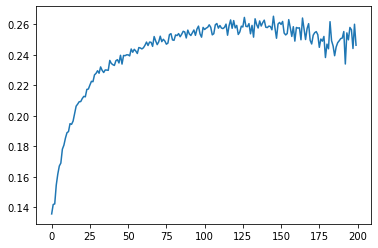

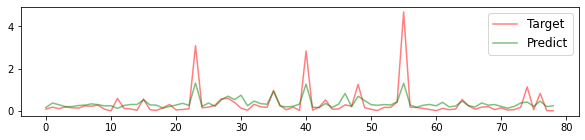

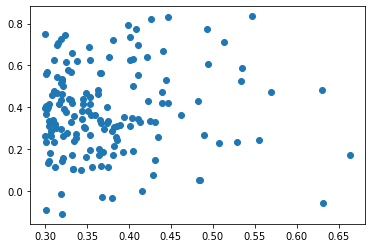

In [18]:
#training VariationalCNN(), record training and validation loss, vbeta=1
tempmodels=['VariationalCNN']
LRs=[0.0003] 
EPOCH=200
train_num=len(train_loader) #number of batches used for training
alpha=None
beta=None
vbeta=1
best_epochs=np.zeros((len(LRs))) # for each LR, the epoch when achieving best val CC
best_valloss=np.zeros((len(LRs))) # for each LR, the best val CC
#
for ii,LR in enumerate(LRs):
    modelname=str(1)
    torch.manual_seed(1)    # reproducible
    torch.cuda.manual_seed(1)
    tempmodel = globals()[tempmodels[0]]()
    optimizer = torch.optim.Adam(tempmodel.parameters(), lr=LR,weight_decay=0.0)
    trainlosses,vallosses=model_train(tempmodel,train_loader[:train_num],optimizer,device,EPOCH,Ploss_L2L1_SE,\
                    alpha=alpha,beta=beta,vbeta=vbeta,earlystop=False,valdata=val_loader,valdevice=device,verbose=False)
    del tempmodel
    torch.cuda.empty_cache()
    best_epochs[ii]  = np.argmax(vallosses)
    best_valloss[ii] = np.max(vallosses)
    print ('{}\n'.format(best_valloss[ii]))
    fig,ax=plt.subplots()
    ax.plot(vallosses)
#
#best_LR = LRs[np.argmax(best_valloss)]
#best_ep = int(best_epochs[np.argmax(best_valloss)]) #epoch
best_LR = LRs[0]
best_ep = int(best_epochs[0])
print ('Best Epoch:{}'.format(best_ep))
best_ep = best_ep + 1
modelname=str(1)
torch.manual_seed(1)    # reproducible
torch.cuda.manual_seed(1)
tempmodel = globals()[tempmodels[0]]()
optimizer = torch.optim.Adam(tempmodel.parameters(), lr=best_LR,weight_decay=0.0)
trainlosses,vallosses=model_train(tempmodel,train_loader[:train_num],optimizer,device,best_ep,Ploss_L2L1_SE,\
                alpha=alpha,beta=beta,vbeta=vbeta,earlystop=False,valdata=val_loader,valdevice=device,verbose=False)
_ = model_test(tempmodel,test_loader,device_cpu,sample_num=100)
testccs,_,_ = model_test_save(tempmodel,test_loader,device_cpu,sample_mean_Flag=False,sample_num=100)
fig,ax=plt.subplots()
ax.scatter(qis,testccs)

In [ ]:
# RF_fl=vis_model_fl(tempmodel,device_cpu,(1,test_loader[0].shape[1],test_loader[0].shape[2],test_loader[0].shape[3]))
# RF_fl_np=RF_fl.cpu().data.numpy()
# RF_fl_np_mean=np.mean(RF_fl_np,axis=0)
# nrows,ncols=1,20
# fig, axes = plt.subplots(nrows=nrows, ncols=ncols,figsize=(15,3))
# for ii in range(20):
#     temp=RF_fl_np_mean[ii,0]
#     tempmax=np.max(np.abs(temp))
#     axes[ii].imshow(temp,vmin=-tempmax,vmax=tempmax,cmap='bwr')
#     axes[ii].grid(False)#axes[ii,jj].axis('tight')
#     axes[ii].set_xticks([])
#     axes[ii].set_yticks([])
del tempmodel
torch.cuda.empty_cache()

## Test MAP

2023-08-31 21:12:29.949206
Epoch: 199 val loss: 0.1072, finish training!
2023-08-31 21:13:20.928818
2023-08-31 21:13:21.148002
Epoch: 8 val loss: 0.2661, finish training!
2023-08-31 21:13:23.473256
Test loss: 0.40285366622739543

2023-08-31 21:13:23.683854
Epoch: 199 val loss: 0.0964, finish training!
2023-08-31 21:14:14.544836
2023-08-31 21:14:14.750240
Epoch: 8 val loss: 0.2661, finish training!
2023-08-31 21:14:17.015324
Test loss: 0.40265572251040344

2023-08-31 21:14:17.218427
Epoch: 199 val loss: 0.1058, finish training!
2023-08-31 21:15:08.492251
2023-08-31 21:15:08.708408
Epoch: 9 val loss: 0.2642, finish training!
2023-08-31 21:15:11.167308
Test loss: 0.3974604876825573

2023-08-31 21:15:11.357628
Epoch: 199 val loss: 0.2347, finish training!
2023-08-31 21:16:03.008495
2023-08-31 21:16:03.222093
Epoch: 62 val loss: 0.2535, finish training!
2023-08-31 21:16:19.311762
Test loss: 0.38010726918034926



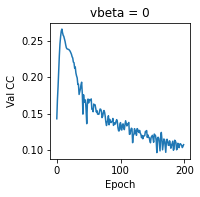

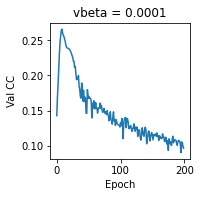

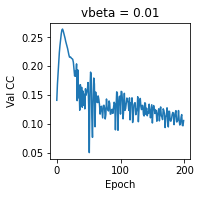

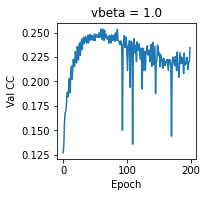

In [23]:
# based on vanilla model, vbetas=1.0, LR=0.0003, EPOCH=200
tempmodels=['VanillaCNN_MAP']
LR=0.0003
EPOCH=200
train_nums=[len(train_loader)] # [2, 4, 6, 8, len(train_loader)] #len(train_loader)
alpha=None
beta=None
vbetas=[0, 1e-4, 1e-2, 1.0]
sampling_number=None
seeds= [1] # np.arange(1,11)
test_losses=np.zeros((len(train_nums),len(seeds)))
model_parameters = {'PI': 0.5, 'SIGMA_1':1 , 'SIGMA_2': 0.00247875}

for ii in range(len(train_nums)):
    for jj in range(len(seeds)):
        for kk in range(len(vbetas)):
            torch.manual_seed(seeds[jj])    # reproducible
            torch.cuda.manual_seed(seeds[jj])
            tempmodel = globals()[tempmodels[0]](**model_parameters)
            optimizer = torch.optim.Adam(tempmodel.parameters(), lr=LR,weight_decay=0.0)
            _,vallosses=model_train_map(tempmodel,train_loader[:train_nums[ii]],optimizer,device,\
                    EPOCH,Ploss_MAP,alpha=alpha,beta=beta,vbeta=vbetas[kk],earlystop=False,valdata=val_loader,\
                    valdevice=device,verbose=False)
            fig, ax = plt.subplots(figsize=(2.5, 2.5))
            ax.plot(vallosses)
            ax.set_xlabel('Epoch')
            ax.set_ylabel('Val CC')
            ax.set_title(f'vbeta = {vbetas[kk]}')
            tempepoch=np.argmax(vallosses)
            tempepoch=tempepoch+1
            del tempmodel
            torch.cuda.empty_cache()
            #
            torch.manual_seed(seeds[jj])    # reproducible
            torch.cuda.manual_seed(seeds[jj])
            tempmodel = globals()[tempmodels[0]](**model_parameters) 
            optimizer = torch.optim.Adam(tempmodel.parameters(), lr=LR,weight_decay=0.0)
            _,_=model_train_map(tempmodel,train_loader[:train_nums[ii]],optimizer,device,tempepoch,Ploss_MAP,\
                    alpha=alpha,beta=beta,vbeta=vbetas[kk],earlystop=False,valdata=val_loader,valdevice=device,verbose=False)
            # torch.save(tempmodel.state_dict(), './out_2YQ_Franke2021/'+ tempmodel.__class__.__name__ +\
            #    '_map_trainnum_' + str(ii) + '_Franke2021Data_trainN_'  + '_seed_' + str(jj) + '.pth')
            test_losses[ii,jj]=model_val(tempmodel,test_loader,device,sample_num=100) #test data, sample 100 times
            print ('Test loss: {}\n'.format(test_losses[ii,jj]))
            #release gpu memory
            del tempmodel
            torch.cuda.empty_cache()

2023-08-31 21:38:26.371508
Epoch: 199 val loss: 0.1474, finish training!
2023-08-31 21:39:17.400441
2023-08-31 21:39:17.617002
Epoch: 9 val loss: 0.2658, finish training!
2023-08-31 21:39:20.144820
Test loss: 0.4018517706926586



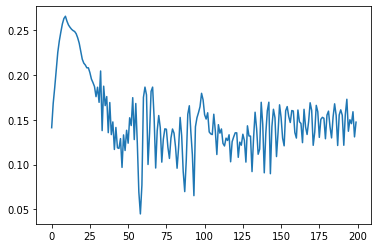

In [25]:
# based on vanilla model, {'PI': 0.5, 'SIGMA_1':1 , 'SIGMA_2': 0.03}
tempmodels=['VanillaCNN_MAP']
LR=0.0003
EPOCH=200
train_nums=[len(train_loader)] # [2, 4, 6, 8, len(train_loader)] #len(train_loader)
alpha=None
beta=None
vbetas=1.0
sampling_number=None
seeds= [1] # np.arange(1,11)
test_losses=np.zeros((len(train_nums),len(seeds)))
model_parameters = {'PI': 0.5, 'SIGMA_1':1 , 'SIGMA_2': 0.03}

for ii in range(len(train_nums)):
    for jj in range(len(seeds)):
        torch.manual_seed(seeds[jj])    # reproducible
        torch.cuda.manual_seed(seeds[jj])
        tempmodel = globals()[tempmodels[0]](**model_parameters)
        optimizer = torch.optim.Adam(tempmodel.parameters(), lr=LR,weight_decay=0.0)
        _,vallosses=model_train_map(tempmodel,train_loader[:train_nums[ii]],optimizer,device,\
                EPOCH,Ploss_MAP,alpha=alpha,beta=beta,vbeta=vbetas,earlystop=False,valdata=val_loader,\
                valdevice=device,verbose=False)
        plt.plot(vallosses)
        tempepoch=np.argmax(vallosses)
        tempepoch=tempepoch+1
        del tempmodel
        torch.cuda.empty_cache()
        #
        torch.manual_seed(seeds[jj])    # reproducible
        torch.cuda.manual_seed(seeds[jj])
        tempmodel = globals()[tempmodels[0]](**model_parameters) 
        optimizer = torch.optim.Adam(tempmodel.parameters(), lr=LR,weight_decay=0.0)
        _,_=model_train_map(tempmodel,train_loader[:train_nums[ii]],optimizer,device,tempepoch,Ploss_MAP,\
                alpha=alpha,beta=beta,vbeta=vbetas,earlystop=False,valdata=val_loader,valdevice=device,verbose=False)
        # torch.save(tempmodel.state_dict(), './out_2YQ_Franke2021/'+ tempmodel.__class__.__name__ +\
        #    '_map_trainnum_' + str(ii) + '_Franke2021Data_trainN_'  + '_seed_' + str(jj) + '.pth')
        test_losses[ii,jj]=model_val(tempmodel,test_loader,device,sample_num=100) #test data, sample 100 times
        print ('Test loss: {}\n'.format(test_losses[ii,jj]))
        #release gpu memory
        # del tempmodel
        torch.cuda.empty_cache()

2023-08-31 21:37:25.641158
Epoch: 199 val loss: 0.1747, finish training!
2023-08-31 21:38:16.399390
2023-08-31 21:38:16.621929
Epoch: 9 val loss: 0.2632, finish training!
2023-08-31 21:38:19.162729
Test loss: 0.3948491498829929



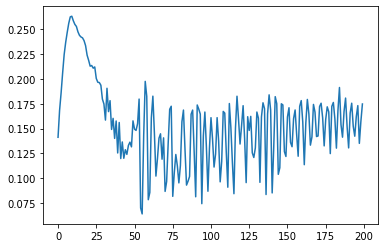

In [24]:
# based on vanilla model, single Gaussian as a prior, vbetas=1.0
tempmodels=['VanillaCNN_MAP']
LR=0.0003
EPOCH=200
train_nums=[len(train_loader)] # [2, 4, 6, 8, len(train_loader)] #len(train_loader)
alpha=None
beta=None
vbetas=1.0
sampling_number=None
seeds= [1] # np.arange(1,11)
test_losses=np.zeros((len(train_nums),len(seeds)))
model_parameters = {'PI': 0.5, 'SIGMA_1':0.03 , 'SIGMA_2': 0.03}

for ii in range(len(train_nums)):
    for jj in range(len(seeds)):
        torch.manual_seed(seeds[jj])    # reproducible
        torch.cuda.manual_seed(seeds[jj])
        tempmodel = globals()[tempmodels[0]](**model_parameters)
        optimizer = torch.optim.Adam(tempmodel.parameters(), lr=LR,weight_decay=0.0)
        _,vallosses=model_train_map(tempmodel,train_loader[:train_nums[ii]],optimizer,device,\
                EPOCH,Ploss_MAP,alpha=alpha,beta=beta,vbeta=vbetas,earlystop=False,valdata=val_loader,\
                valdevice=device,verbose=False)
        plt.plot(vallosses)
        tempepoch=np.argmax(vallosses)
        tempepoch=tempepoch+1
        del tempmodel
        torch.cuda.empty_cache()
        #
        torch.manual_seed(seeds[jj])    # reproducible
        torch.cuda.manual_seed(seeds[jj])
        tempmodel = globals()[tempmodels[0]](**model_parameters) 
        optimizer = torch.optim.Adam(tempmodel.parameters(), lr=LR,weight_decay=0.0)
        _,_=model_train_map(tempmodel,train_loader[:train_nums[ii]],optimizer,device,tempepoch,Ploss_MAP,\
                alpha=alpha,beta=beta,vbeta=vbetas,earlystop=False,valdata=val_loader,valdevice=device,verbose=False)
        # torch.save(tempmodel.state_dict(), './out_2YQ_Franke2021/'+ tempmodel.__class__.__name__ +\
        #    '_map_trainnum_' + str(ii) + '_Franke2021Data_trainN_'  + '_seed_' + str(jj) + '.pth')
        test_losses[ii,jj]=model_val(tempmodel,test_loader,device,sample_num=100) #test data, sample 100 times
        print ('Test loss: {}\n'.format(test_losses[ii,jj]))
        #release gpu memory
        # del tempmodel
        torch.cuda.empty_cache()

## Test MAP different prior distribution
mixture of Gaussian, Gaussian with small std, Gaussian with large std

2023-09-03 15:08:57.143038
Epoch: 199 val loss: 0.0992, finish training!
2023-09-03 15:09:50.587904
0.2660965980011061

2023-09-03 15:09:50.809775
Epoch: 199 val loss: 0.1092, finish training!
2023-09-03 15:10:44.301536
0.2660216493707505

2023-09-03 15:10:44.504733
Epoch: 199 val loss: 0.1562, finish training!
2023-09-03 15:11:37.879301
0.2603237822457355

2023-09-03 15:11:38.083509
Epoch: 199 val loss: 0.2110, finish training!
2023-09-03 15:12:31.253690
0.24931755795153812

2023-09-03 15:12:31.474419
Epoch: 199 val loss: 0.0989, finish training!
2023-09-03 15:13:24.937757
0.26609485354035856

2023-09-03 15:13:25.144774
Epoch: 199 val loss: 0.1144, finish training!
2023-09-03 15:14:18.400614
0.2660229308157762

2023-09-03 15:14:18.610942
Epoch: 199 val loss: 0.1395, finish training!
2023-09-03 15:15:11.985774
0.26537675081200335

2023-09-03 15:15:12.200129
Epoch: 199 val loss: 0.2251, finish training!
2023-09-03 15:16:05.602629
0.24941969245599696

2023-09-03 15:16:05.823662
Epoch: 19

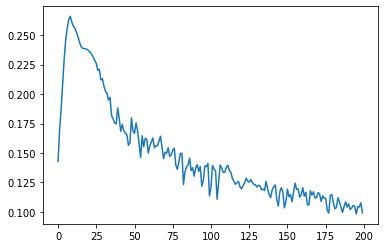

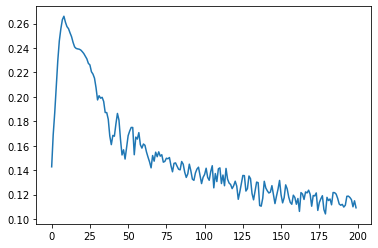

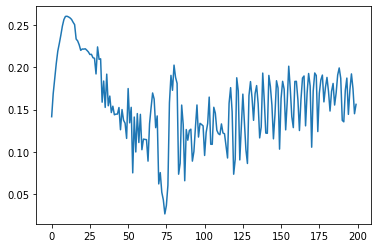

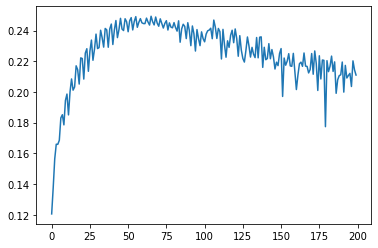

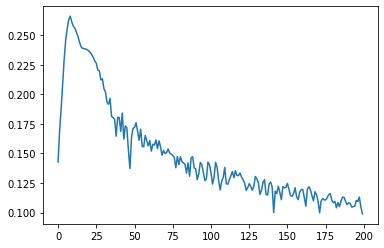

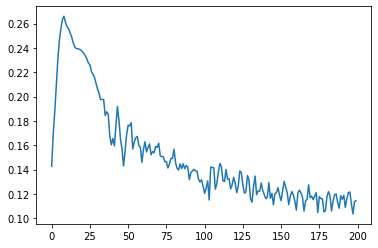

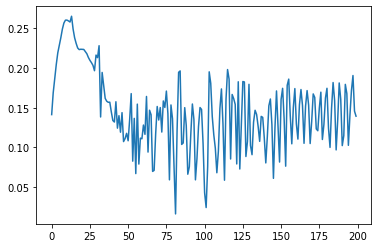

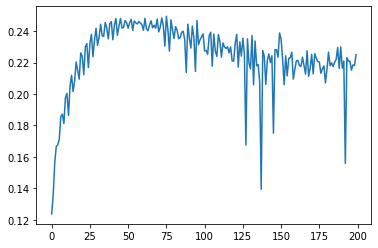

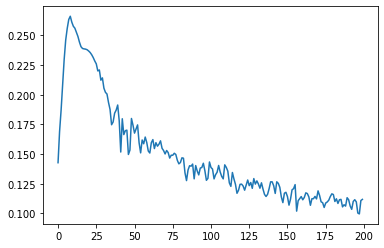

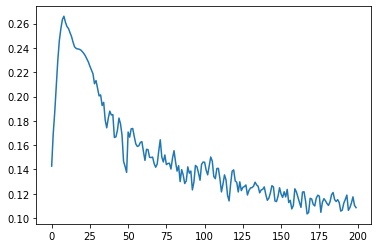

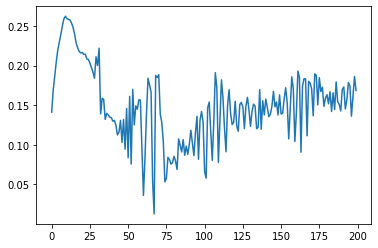

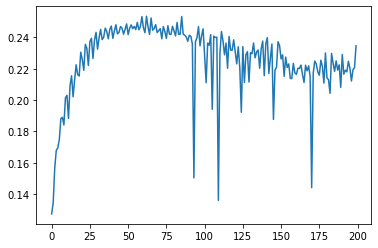

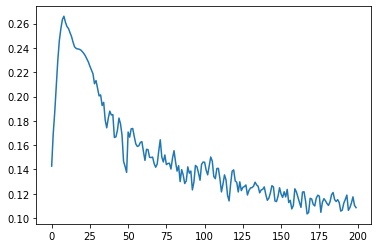

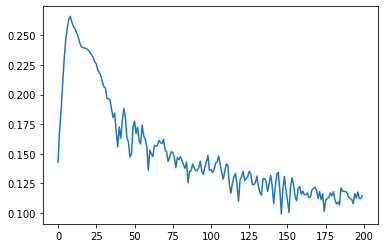

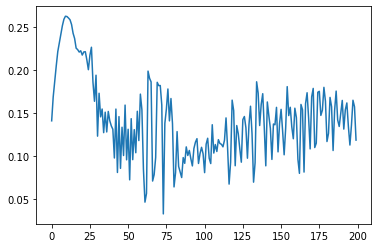

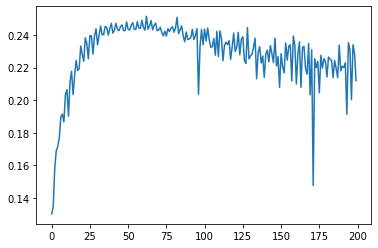

In [17]:
tempmodels=['VanillaCNN_MAP']
LR=0.0003
EPOCH=200
train_num=len(train_loader)
alpha=0
beta=0
vbeta=1.0
pis = [0.5]    
sigma1s = [100, 10, 1, 0.2]
sigma2s=[1, 0.2, 0.02, 0.00247875]

train_val_loss=np.zeros((2,(len(pis)*len(sigma1s)*len(sigma2s)),EPOCH))
best_epochs=np.zeros((len(pis)*len(sigma1s)*len(sigma2s))) # for each mixture, the epoch when achieving best val CC
best_valloss=np.zeros((len(pis)*len(sigma1s)*len(sigma2s))) # for each mixture, the best val CC
kk=0
for pi in pis:
    for s1 in sigma1s:
        for s2 in sigma2s:
            model_parameters = {'PI':pi, 'SIGMA_1':s1, 'SIGMA_2':s2}
            modelname=str(kk)
            torch.manual_seed(1)    # reproducible
            torch.cuda.manual_seed(1)
            tempmodel = globals()[tempmodels[0]](**model_parameters)
            optimizer = torch.optim.Adam(tempmodel.parameters(), lr=LR,weight_decay=0.0)
            trainlosses,vallosses=model_train_map(tempmodel,train_loader[:train_num],optimizer,device,EPOCH,Ploss_MAP,\
                                alpha=alpha,beta=beta,vbeta=vbeta,earlystop=False,valdata=val_loader,valdevice=device,verbose=False)
            train_val_loss[0,kk],train_val_loss[1,kk]=trainlosses,vallosses
            del tempmodel
            torch.cuda.empty_cache()
            best_epochs[kk]= np.argmax(vallosses)
            best_valloss [kk]= np.max(vallosses)
            print ('{}\n'.format(best_valloss[kk]))
            fig,ax=plt.subplots()
            ax.plot(vallosses)
            kk=kk+1
                     
temp2=np.reshape(np.array(best_valloss),(1,4,4))
print(temp2)            
best_kk=int(np.argmax(best_valloss))
best_a,aaa=divmod(best_kk,len(sigma1s)*len(sigma2s))
best_b,bbb=divmod(aaa,len(sigma2s))
best_pi=pis[best_a]
best_sigma1=sigma1s[best_b]
best_sigma2=sigma2s[bbb]
best_ep = int(best_epochs[np.argmax(best_valloss)]) #epoch
print ('Best pi: {} Best sigma1: {} Best sigma2: {} and Best epoch: {} '.format(best_pi, best_sigma1,best_sigma2,best_ep))


In [15]:
#np.save('out_20220423/CNN_MAP_train_val_loss_mixture_Gaussian.npy', train_val_loss)

## CNN with the best regularizations 

In [ ]:
#training VanillaCNN(), record training and validation loss
tempmodels=['VanillaCNN']
LR=0.0003     #best LR 
EPOCH=200
train_num=len(train_loader)
alphas_1=[0.0, 100,  1000, 10000, 100000]     #conv1, [0.0, 100,  1000, 10000, 100000]
alphas_2=[0.0, 100,  1000, 10000, 100000]     #conv2, [0.0, 100,  1000, 10000, 100000] 
betas   =[0.0, 0.03, 0.1,  0.3,   1]             #fl, [0.0, 0.03, 0.1,  0.3,   1]  
vbeta=None
best_epochs=np.zeros((len(betas)*len(alphas_1)*len(alphas_2))) # for each train_num, the epoch when achieving best val CC
best_valloss=np.zeros((len(betas)*len(alphas_1)*len(alphas_2))) # for each train_num, the best val CC
train_val_loss=np.zeros((2,(len(betas)*len(alphas_1)*len(alphas_2)),EPOCH))
qq=0
#
for ii in range(len(alphas_1)):
    for jj in range(len(alphas_2)):
        for kk in range(len(betas)):
            modelname=str(qq)
            torch.manual_seed(1)    # reproducible
            torch.cuda.manual_seed(1)
            tempmodel = globals()[tempmodels[0]]()
            optimizer = torch.optim.Adam(tempmodel.parameters(), lr=LR,weight_decay=0.0)
            trainlosses,vallosses=model_train_regularization_2conv(tempmodel,train_loader[:train_num],optimizer,\
                    device,EPOCH,Ploss_L2L1_SE_regularizaion_2conv,alpha1=alphas_1[ii],alpha2=alphas_2[jj],\
                    beta=betas[kk],vbeta=vbeta,earlystop=False,valdata=val_loader,valdevice=device,verbose=False)
            train_val_loss[0,qq],train_val_loss[1,qq]=trainlosses,vallosses
            del tempmodel
            torch.cuda.empty_cache()
            best_epochs[qq]  = np.argmax(vallosses)
            best_valloss[qq] = np.max(vallosses)
            print ('{}\n'.format(best_valloss[kk]))
            fig,ax=plt.subplots()
            ax.plot(vallosses)
            qq=qq+1
#
temp2=np.reshape(np.array(best_valloss),(len(alphas_1),len(alphas_2),len(betas)))
print(temp2)

In [ ]:
#np.save('out_2YQ_Franke2021/CNN_regularizations_train_val_loss.npy', train_val_loss)

In [ ]:
tempmodels=['VanillaCNN']
best_kk=int(np.argmax(best_valloss))
best_a,yyy=divmod(best_kk,len(alphas_2)*len(betas))
best_b, best_c=divmod(yyy,len(betas))
best_alpha1=alphas_1[best_a]
best_alpha2=alphas_2[best_b]
best_beta=betas[best_c]
best_ep = int(best_epochs[np.argmax(best_valloss)]) #epoch
print ('Best alpha1: {} Best alpha2: {}  Best beta: {} and Epoch:{}'.format(best_alpha1,best_alpha2,best_beta,best_ep))
print ('Best val loss: {}'.format(np.max(best_valloss)))
best_ep = best_ep + 1
modelname=str(1)
torch.manual_seed(1)    # reproducible
torch.cuda.manual_seed(1)
tempmodel = globals()[tempmodels[0]]()
optimizer = torch.optim.Adam(tempmodel.parameters(), lr=LR,weight_decay=0.0)
trainlosses,vallosses=model_train_regularization_2conv(tempmodel,train_loader[:train_num],optimizer,\
                device,best_ep,Ploss_L2L1_SE_regularizaion_2conv,alpha1=best_alpha1,alpha2=best_alpha2,\
                beta=best_beta,vbeta=vbeta,earlystop=False,valdata=val_loader,valdevice=device,verbose=False)
_ = model_test(tempmodel,test_loader,device_cpu,sample_num=100)
# RF_fl=vis_model_fl(tempmodel,device_cpu,(1,test_loader[0].shape[1],test_loader[0].shape[2],test_loader[0].shape[3]))
# RF_fl_np=RF_fl.cpu().data.numpy()
# #RF_fl_np_mean=np.mean(RF_fl_np,axis=0)
# nrows,ncols=1,20
# fig, axes = plt.subplots(nrows=nrows, ncols=ncols,figsize=(15,3))
# for ii in range(20):
#     temp=RF_fl_np[ii,0]
#     tempmax=np.max(np.abs(temp))
#     axes[ii].imshow(temp,vmin=-tempmax,vmax=tempmax,cmap='bwr')
#     axes[ii].grid(False)#axes[ii,jj].axis('tight')
#     axes[ii].set_xticks([])
#     axes[ii].set_yticks([])
del tempmodel
torch.cuda.empty_cache()

In [ ]:
train_val_loss=np.load('out_2YQ_Franke2021/CNN_regularizations_train_val_loss.npy')
print(np.max(train_val_loss[1]))
#print(np.max(train_val_loss[1,227]))
plt.plot(train_val_loss[1,np.argmax(np.max(train_val_loss[1],axis=1))])

## CNN with MC dropout

In [ ]:
#np.save('out_2YQ_Franke2021/CNN_MCdropout_train_val_loss.npy', train_val_loss)

In [ ]:
#train_val_loss=np.load('out_2YQ_Franke2021/CNN_MCdropout_train_val_loss.npy')
#print(np.max(train_val_loss[1]))
#print(np.max(train_val_loss[1,141]))
#print(np.argmax(train_val_loss[1,141]))

In [ ]:
tempmodels=['VanillaCNN_Dropout']   #MC dropout
LRs=0.0003     #best LR 
EPOCH=200
train_num=len(train_loader)
alpha=0
beta=0
vbeta=None
drop_out_num=100
dropout_p=[0.01,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9] # use 0.01 instead of 0 for very small dropout rates
train_val_loss=np.zeros((2,len(dropout_p),EPOCH))
best_epochs=np.zeros(len(dropout_p)) 
best_valloss=np.zeros(len(dropout_p)) 
for ii in range(len(dropout_p)):
    model_parameters = {'p':dropout_p[ii]}
    modelname=str(ii)
    torch.manual_seed(1)    # reproducible
    torch.cuda.manual_seed(1)
    tempmodel = globals()[tempmodels[0]](**model_parameters)
    optimizer = torch.optim.Adam(tempmodel.parameters(), lr=LRs,weight_decay=0.0)
    trainlosses,vallosses=model_train_drop_out(tempmodel,train_loader[:train_num],optimizer,device,EPOCH,Ploss_L2L1_SE,\
                    drop_out_num,alpha=alpha,beta=beta,vbeta=vbeta,earlystop=False,valdata=val_loader,valdevice=device,verbose=False)
    train_val_loss[0,ii],train_val_loss[1,ii]=trainlosses,vallosses
    del tempmodel
    torch.cuda.empty_cache()
    best_epochs[ii]  = np.argmax(vallosses)
    best_valloss[ii] = np.max(vallosses)
    print ('{}\n'.format(best_valloss[ii]))
    fig,ax=plt.subplots()
    ax.plot(vallosses)
    
temp2=np.reshape(np.array(best_valloss),(10,1))
print(temp2) 

2022-05-16 18:05:31.222062
Epoch: 199 val loss: 0.1069, finish training!
2022-05-16 18:24:21.395985
0.26443996210880305

2022-05-16 18:24:21.688510
Epoch: 199 val loss: 0.1349, finish training!
2022-05-16 18:43:03.707562
0.2658858276545062

2022-05-16 18:43:04.081855


In [ ]:
tempmodels=['VanillaCNN_Dropout']   #MC dropout
best_kk=int(np.argmax(best_valloss))
best_p=dropout_p[best_kk]
best_ep = int(best_epochs[best_kk]) #epoch
print ('Best dropout rate: {} and Epoch:{}'.format(best_p, best_ep))
best_ep = best_ep + 1
modelname=str(1)
model_parameters = {'p':best_p}
torch.manual_seed(1)    # reproducible
torch.cuda.manual_seed(1)
tempmodel = globals()[tempmodels[0]](**model_parameters)
optimizer = torch.optim.Adam(tempmodel.parameters(), lr=LR,weight_decay=0.0)
trainlosses,vallosses=model_train_drop_out(tempmodel,train_loader[:train_num],optimizer,device,best_ep,Ploss_L2L1_SE,drop_out_num, alpha=alpha,beta=beta,vbeta=vbeta,earlystop=False,valdata=val_loader,valdevice=device,verbose=False)
_ = model_val_drop_out(tempmodel,test_loader,device_cpu,drop_out_num=100, sample_num=100, plot_flag=True)
# RF_fl=vis_model_fl_dropout(tempmodel,device_cpu,(1,test_loader[0].shape[1],test_loader[0].shape[2],test_loader[0].shape[3]))
# RF_fl_np=RF_fl.cpu().data.numpy()
# RF_fl_np_mean=np.mean(RF_fl_np,axis=0)
# nrows,ncols=1,20
# fig, axes = plt.subplots(nrows=nrows, ncols=ncols,figsize=(15,3))
# for ii in range(20):
#     temp=RF_fl_np_mean[ii,0]
#     tempmax=np.max(np.abs(temp))
#     axes[ii].imshow(temp,vmin=-tempmax,vmax=tempmax,cmap='bwr')
#     axes[ii].grid(False)#axes[ii,jj].axis('tight')
#     axes[ii].set_xticks([])
#     axes[ii].set_yticks([])
del tempmodel
torch.cuda.empty_cache()

In [ ]:
#np.save('out_2YQ_Franke2021/CNN_MCdropout_train_val_loss_defaults.npy', train_val_loss)

In [ ]:
#somehow, for this data, only one seed could not select the best dropout rate, so here we select the dropout 
#based on 10 seeds
tempmodels=['VanillaCNN_Dropout']   #MC dropout
LRs=0.0003     #best LR 
EPOCH=200
train_num=len(train_loader)
alpha=0
beta=0
vbeta=None
seeds=np.arange(1,11)
drop_out_num=100
dropout_p=[0.01,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9] # use 0.01 instead of 0 for very small dropout rates
#train_val_loss=np.zeros((2,len(dropout_p),EPOCH))
#best_epochs=np.zeros(len(dropout_p)) 
best_valloss=np.zeros((len(dropout_p), len(seeds))) 
for ii in range(len(dropout_p)):
    for jj in range(len(seeds)):
        model_parameters = {'p':dropout_p[ii]}
        modelname=str(ii)
        torch.manual_seed(seeds[jj])    # reproducible
        torch.cuda.manual_seed(seeds[jj])
        tempmodel = globals()[tempmodels[0]](**model_parameters)
        optimizer = torch.optim.Adam(tempmodel.parameters(), lr=LRs,weight_decay=0.0)
        trainlosses,vallosses=model_train_drop_out(tempmodel,train_loader[:train_num],optimizer,device,\
                    EPOCH,Ploss_L2L1_SE,drop_out_num,alpha=alpha,beta=beta,vbeta=vbeta,earlystop=False,\
                    valdata=val_loader,valdevice=device,verbose=False)
        #train_val_loss[0,ii],train_val_loss[1,ii]=trainlosses,vallosses
        del tempmodel
        torch.cuda.empty_cache()
        #best_epochs[ii]  = np.argmax(vallosses)
        best_valloss[ii,jj] = np.max(vallosses)

In [ ]:
print ('Best dropout rate: {}'.format(dropout_p[np.argmax(np.mean(best_valloss, axis=1))]))
print (np.mean(best_valloss, axis=1))
print (best_valloss)

## Tune the best beta

In [ ]:
tempmodels=['VanillaCNN','VariationalCNN','VariationalCNN','VariationalCNN','VariationalCNN','VariationalCNN']
LR=0.0003
EPOCH=200
train_nums=len(train_loader)  
alpha=0
beta=0
vbetas=[None, 0.1, 0.3, 1.0, 3.0, 10]
train_val_loss=np.zeros((2,len(tempmodels),EPOCH)) # 2: train and val loss
best_epochs=np.zeros(len(tempmodels)) 
best_valloss=np.zeros(len(tempmodels)) 
#
for ii in range(len(tempmodels)):
    modelname=str(1)
    torch.manual_seed(1)    # reproducible
    torch.cuda.manual_seed(1)
    tempmodel = globals()[tempmodels[ii]]() #tempmodels[ii]
    optimizer = torch.optim.Adam(tempmodel.parameters(), lr=LR,weight_decay=0.0)
    #temp=model_train(tempmodel,train_loader,optimizer,device,50,Ploss_L2L1_SE,alpha=None,beta=None)
    trainlosses,vallosses=model_train(tempmodel,train_loader[:train_nums],optimizer,device,EPOCH,Ploss_L2L1_SE,\
                    alpha=alpha,beta=beta,vbeta=vbetas[ii],earlystop=False,valdata=val_loader,valdevice=device,verbose=False)
    train_val_loss[0,ii],train_val_loss[1,ii]=trainlosses,vallosses
    #modeltrainloss.append(temp)
    #torch.save(tempmodel.state_dict(), './out_20200810/VariationalLN_SimulationData_'+modelname+'.pth')
    #temp=model_val(tempmodel,val_loader,20,device_cpu,loss_mse)
    #modelvalloss.append(temp)
    #release gpu memory
    del tempmodel
    torch.cuda.empty_cache()
    best_epochs[ii]  = np.argmax(vallosses)
    best_valloss[ii] = np.max(vallosses)
    print ('{}\n'.format(best_valloss[ii]))
    fig,ax=plt.subplots()
    ax.plot(vallosses)
#
print (train_val_loss.shape)

In [ ]:
#np.save('out_2YQ_Franke2021/CNN_train_val_loss_beta.npy', train_val_loss)

In [ ]:
tempmodels = ['VariationalCNN']   
best_kk = int(np.argmax(best_valloss))
best_vbeta = vbetas[best_kk]
best_ep = int(best_epochs[best_kk]) #epoch
print ('Best vbeta: {} and Epoch:{}'.format(best_vbeta, best_ep))
best_ep = best_ep + 1
modelname=str(1)
torch.manual_seed(1)    # reproducible
torch.cuda.manual_seed(1)
tempmodel = globals()[tempmodels[0]]()
optimizer = torch.optim.Adam(tempmodel.parameters(), lr=LR,weight_decay=0.0)
trainlosses,vallosses=model_train(tempmodel,train_loader[:train_num],optimizer,device,best_ep,Ploss_L2L1_SE,\
                alpha=alpha,beta=beta,vbeta=best_vbeta,earlystop=False,valdata=val_loader,valdevice=device,verbose=False)
#
_ = model_test(tempmodel,test_loader,device_cpu,sample_num=100)
#
testccs,_,_ = model_test_save(tempmodel,test_loader,device_cpu,sample_mean_Flag=False,sample_num=100)
fig,ax=plt.subplots()
ax.scatter(qis,testccs)
#
# RF_fl=vis_model_fl(tempmodel,device_cpu,(1,test_loader[0].shape[1],test_loader[0].shape[2],test_loader[0].shape[3]))
# RF_fl_np=RF_fl.cpu().data.numpy()
# RF_fl_np_mean=np.mean(RF_fl_np,axis=0)
# nrows,ncols=1,20
# fig, axes = plt.subplots(nrows=nrows, ncols=ncols,figsize=(15,3))
# for ii in range(20):
#     temp=RF_fl_np_mean[ii,0]
#     tempmax=np.max(np.abs(temp))
#     axes[ii].imshow(temp,vmin=-tempmax,vmax=tempmax,cmap='bwr')
#     axes[ii].grid(False)#axes[ii,jj].axis('tight')
#     axes[ii].set_xticks([])
#     axes[ii].set_yticks([])
del tempmodel
torch.cuda.empty_cache()

In [ ]:
train_val_loss=np.load('out_2YQ_Franke2021/CNN_train_val_loss_beta.npy')
print (train_val_loss.shape)
print(np.max(train_val_loss[1,0]))
print(np.max(train_val_loss[1,1]))
print(np.max(train_val_loss[1,2]))
print(np.max(train_val_loss[1,3]))
print(np.max(train_val_loss[1,4]))
print(np.max(train_val_loss[1,5]))
#print(np.max(train_val_loss[1,6]))

In [ ]:
fig,ax=plt.subplots(nrows=1,ncols=1,figsize=(3,3))
ax.plot(train_val_loss[1,0,:],color='k',linestyle='-',label='CNN')
ax.plot(train_val_loss[1,1,:],color='r',linestyle='-',label='VCNN, $\\beta$=0.1')
ax.plot(train_val_loss[1,2,:],color='g',linestyle='-',label='VCNN, $\\beta$=0.3')
ax.plot(train_val_loss[1,3,:],color='b',linestyle='-',label='VCNN, $\\beta$=1.0')
ax.plot(train_val_loss[1,4,:],color='c',linestyle='-',label='VCNN, $\\beta$=3.0')
ax.plot(train_val_loss[1,5,:],color='y',linestyle='-',label='VCNN, $\\beta$=10')
#ax.plot(train_val_loss[1,6,:],color='m',linestyle='-',label='VCNN, $\\beta$=3.0')
#for ii in range(len(lossweights)):
#    ax.plot(train_val_loss[1,3,:100],color=colors[ii],label='{}'.format(lossweights[ii]))
ax.legend(loc='best',frameon=False)
ax.set_xlim([0, 200])
ax.set_ylim([0.0, 0.4])
ax.set_xticks([0, 100, 200])
ax.set_yticks([0,0.2,0.4])
ax.set_xlabel('Epoch', fontsize=16)
ax.set_ylabel('Val Overall CC', fontsize=16)
adjust_spines(ax, ['left', 'bottom'])
handles, labels = ax.get_legend_handles_labels()
lgd = ax.legend(handles, labels, loc='center left',frameon=False, bbox_to_anchor=(1, 0.5))
#fig.savefig('out_result_20220423/VariationalCNN_SimulationData_seed_1_valloss_beta.svg',bbox_extra_artists=(lgd,), bbox_inches='tight')

## Test different prior distribution
mixture of Gaussian, Gaussian with small std, Gaussian with large std

In [ ]:
tempmodels=['VariationalCNN']
LR=0.0003
EPOCH=200
train_num=len(train_loader)
alpha=0
beta=0
vbeta=0.1
pis = [0.2, 0.5, 0.8]    
sigma1s = [1, 10, 100]
sigma2s=[0.04978706, 0.00247875, 0.00012341]

train_val_loss=np.zeros((2,(len(pis)*len(sigma1s)*len(sigma2s)),EPOCH))
best_epochs=np.zeros((len(pis)*len(sigma1s)*len(sigma2s))) # for each mixture, the epoch when achieving best val CC
best_valloss=np.zeros((len(pis)*len(sigma1s)*len(sigma2s))) # for each mixture, the best val CC
kk=0
for pi in pis:
    for s1 in sigma1s:
        for s2 in sigma2s:
            model_parameters = {'PI':pi, 'SIGMA_1':s1, 'SIGMA_2':s2}
            modelname=str(kk)
            torch.manual_seed(1)    # reproducible
            torch.cuda.manual_seed(1)
            tempmodel = globals()[tempmodels[0]](**model_parameters)
            optimizer = torch.optim.Adam(tempmodel.parameters(), lr=LR,weight_decay=0.0)
            trainlosses,vallosses=model_train(tempmodel,train_loader[:train_num],optimizer,device,EPOCH,Ploss_L2L1_SE,\
                                alpha=alpha,beta=beta,vbeta=vbeta,earlystop=False,valdata=val_loader,valdevice=device,verbose=False)
            train_val_loss[0,kk],train_val_loss[1,kk]=trainlosses,vallosses
            del tempmodel
            torch.cuda.empty_cache()
            best_epochs[kk]= np.argmax(vallosses)
            best_valloss [kk]= np.max(vallosses)
            print ('{}\n'.format(best_valloss[kk]))
            fig,ax=plt.subplots()
            ax.plot(vallosses)
            kk=kk+1
                     
temp2=np.reshape(np.array(best_valloss),(3,3,3))
print(temp2)            
best_kk=int(np.argmax(best_valloss))
best_a,aaa=divmod(best_kk,len(sigma1s)*len(sigma2s))
best_b,bbb=divmod(aaa,len(sigma2s))
best_pi=pis[best_a]
best_sigma1=sigma1s[best_b]
best_sigma2=sigma2s[bbb]
best_ep = int(best_epochs[np.argmax(best_valloss)]) #epoch
print ('Best pi: {} Best sigma1: {} Best sigma2: {} and Best epoch: {} '.format(best_pi, best_sigma1,best_sigma2,best_ep))


In [ ]:
#np.save('temp/dataFranke_VCNN_best_valloss_mixture_Gaussian_defaults.npy',best_valloss)

In [15]:
best_kk=int(np.argmax(best_valloss))
best_a,aaa=divmod(best_kk,len(sigma1s)*len(sigma2s))
best_b,bbb=divmod(aaa,len(sigma2s))
best_pi=pis[best_a]
best_sigma1=sigma1s[best_b]
best_sigma2=sigma2s[bbb]
best_ep = int(best_epochs[np.argmax(best_valloss)]) #epoch
print ('Best pi: {} Best sigma1: {} Best sigma2: {} and Best epoch: {} '.format(best_pi, best_sigma1,best_sigma2,best_ep))

Best pi: 0.5 Best sigma1: 100 Best sigma2: 0.00012341 and Best epoch: 87 


In [16]:
print(temp2)

[[[0.2653763  0.27387806 0.27639153]
  [0.26542385 0.27521598 0.27830422]
  [0.26541002 0.27752178 0.27844993]]

 [[0.26537889 0.2741233  0.27548226]
  [0.2653687  0.27403011 0.27642135]
  [0.26543378 0.27646317 0.27961465]]

 [[0.26529824 0.27423547 0.27519273]
  [0.26537328 0.27366755 0.27804691]
  [0.26541106 0.2746298  0.27925764]]]


In [ ]:
#np.save('out_2YQ_Franke2021/VCNN_train_val_loss_mixture_Gaussian_defaults.npy', train_val_loss)

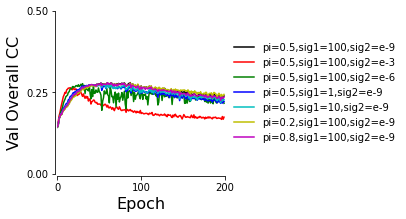

In [18]:
train_val_loss=np.load('out_2YQ_Franke2021/VCNN_train_val_loss_mixture_Gaussian_defaults.npy')
fig,ax=plt.subplots(nrows=1,ncols=1,figsize=(3,3))
ax.plot(train_val_loss[1,17,:],color='k',linestyle='-',label='pi=0.5,sig1=100,sig2=e-9')
ax.plot(train_val_loss[1,15,:],color='r',linestyle='-',label='pi=0.5,sig1=100,sig2=e-3')
ax.plot(train_val_loss[1,16,:],color='g',linestyle='-',label='pi=0.5,sig1=100,sig2=e-6')
ax.plot(train_val_loss[1,11,:],color='b',linestyle='-',label='pi=0.5,sig1=1,sig2=e-9')
ax.plot(train_val_loss[1,14,:],color='c',linestyle='-',label='pi=0.5,sig1=10,sig2=e-9')
ax.plot(train_val_loss[1,8,:],color='y',linestyle='-',label='pi=0.2,sig1=100,sig2=e-9')
ax.plot(train_val_loss[1,26,:],color='m',linestyle='-',label='pi=0.8,sig1=100,sig2=e-9')

ax.legend(loc='best',frameon=False)
ax.set_xlim([0, 200])
ax.set_ylim([0.0, 0.5])
ax.set_xticks([0, 100, 200])
ax.set_yticks([0, 0.25, 0.5])
ax.set_xlabel('Epoch', fontsize=16)
ax.set_ylabel('Val Overall CC', fontsize=16)
adjust_spines(ax, ['left', 'bottom'])
handles, labels = ax.get_legend_handles_labels()
lgd = ax.legend(handles, labels, loc='center left',frameon=False, bbox_to_anchor=(1, 0.5))
#fig.savefig('out_result_20220423/mixture_Gaussian_train_val_loss_VCNN.svg',bbox_extra_artists=(lgd,), bbox_inches='tight')

## Test different sampling times

In [ ]:
tempmodels=['VariationalCNN']
LR=0.0003
EPOCH=200
train_num=len(train_loader)
alpha=0
beta=0
vbeta=0.1
sampling_number=[1,2,4,8,16]
train_val_loss=np.zeros((2,len(sampling_number),EPOCH))
best_epochs=np.zeros((len(sampling_number)))
best_valloss=np.zeros((len(sampling_number)))
model_parameters = {'PI': 0.5, 'SIGMA_1':1 , 'SIGMA_2': 0.00247875}
for ii in range(len(sampling_number)):
    modelname=str(1)
    torch.manual_seed(1)    # reproducible
    torch.cuda.manual_seed(1)
    tempmodel = globals()[tempmodels[0]](**model_parameters)
    optimizer = torch.optim.Adam(tempmodel.parameters(), lr=LR,weight_decay=0.0)
    trainlosses,vallosses=model_train_sample_num(tempmodel,train_loader[:train_num],optimizer,device,EPOCH,Ploss_L2L1_SE,\
                        alpha=alpha,beta=beta,vbeta=vbeta,earlystop=False,valdata=val_loader,valdevice=device,verbose=False,sampling_num=sampling_number[ii])
    train_val_loss[0,ii],train_val_loss[1,ii]=trainlosses,vallosses
    del tempmodel
    torch.cuda.empty_cache()
    best_epochs[ii]  = np.argmax(vallosses)
    best_valloss[ii] = np.max(vallosses)
    print ('{}\n'.format(best_valloss[ii]))
    fig,ax=plt.subplots()
    ax.plot(vallosses)

temp2=np.reshape(np.array(best_valloss),(5,1))
print(temp2) 
best_sampling_num= sampling_number[np.argmax(best_valloss)]
best_ep = int(best_epochs[np.argmax(best_valloss)]) #epoch
print ('Best sampling_num: {} and Epoch:{}'.format(best_sampling_num,best_ep))

In [ ]:
# np.save('out_2YQ_Franke2021/VCNN_train_val_loss_sample_num.npy',train_val_loss)

In [ ]:
train_val_loss=np.load('out_2YQ_Franke2021/VCNN_train_val_loss_sample_num.npy')
fig,ax=plt.subplots(nrows=1,ncols=1,figsize=(3,3))
ax.plot(train_val_loss[1,0,:],color='k',linestyle='-',label='sample_num=1')
ax.plot(train_val_loss[1,1,:],color='r',linestyle='-',label='sample_num=2')
ax.plot(train_val_loss[1,2,:],color='g',linestyle='-',label='sample_num=4')
ax.plot(train_val_loss[1,3,:],color='b',linestyle='-',label='sample_num=8')
ax.plot(train_val_loss[1,4,:],color='c',linestyle='-',label='sample_num=16')
ax.legend(loc='best',frameon=False)
ax.set_xlim([0, 200])
ax.set_ylim([0, 0.5])
ax.set_xticks([0, 100, 200])
ax.set_yticks([0,0.25,0.5])
ax.set_xlabel('Epoch', fontsize=16)
ax.set_ylabel('Val Overall CC', fontsize=16)
adjust_spines(ax, ['left', 'bottom'])
handles, labels = ax.get_legend_handles_labels()
lgd = ax.legend(handles, labels, loc='center left',frameon=False, bbox_to_anchor=(1, 0.5))
#fig.savefig('out_result_20211216/VCNN_seed_1_train_val_loss_sample_num.svg',bbox_extra_artists=(lgd,), bbox_inches='tight')

## CNN with regularizations vs. best varitionalCNN vs. CNN with dropout

#### Validation loss against epoch number

In [ ]:
train_val_loss_CNN_L1L2=np.load('out_2YQ_Franke2021/CNN_regularizations_train_val_loss.npy')
train_val_loss_VCNN=np.load('out_2YQ_Franke2021/VCNN_train_val_loss_sample_num.npy')
train_val_loss_CNN_dropout=np.load('out_2YQ_Franke2021/CNN_MCdropout_train_val_loss_defaults.npy')
print(np.max(train_val_loss_CNN_L1L2[1]))
print(np.max(train_val_loss_VCNN[1]))
print(np.max(train_val_loss_CNN_dropout[1]))
print(np.max(train_val_loss_CNN_L1L2[1,227]))
print(np.max(train_val_loss_VCNN[1,1]))
print(np.max(train_val_loss_CNN_dropout[1,7]))

fig,ax=plt.subplots(nrows=1,ncols=1,figsize=(3,3))
ax.plot(train_val_loss_CNN_L1L2[1,227,:],color='r',linestyle='-',label='CNN with regularizations')
ax.plot(train_val_loss_VCNN[1,1,:],color='g',linestyle='-',label='VCNN')
ax.plot(train_val_loss_CNN_dropout[1,7,:],color='b',linestyle='-',label='CNN with dropout')
ax.legend(loc='best',frameon=False)
ax.set_xlim([0, 200])
ax.set_ylim([0.0,0.5])
ax.set_xticks([0, 100, 200])
ax.set_yticks([0,0.25,0.5])
ax.set_xlabel('Epoch', fontsize=16)
ax.set_ylabel('Val Overall CC', fontsize=16)
adjust_spines(ax, ['left', 'bottom'])
handles, labels = ax.get_legend_handles_labels()
lgd = ax.legend(handles, labels, loc='center left',frameon=False, bbox_to_anchor=(1, 0.5))
#fig.savefig('out_result_20211216/Validation_loss_against_epoch_number_CNN.svg',bbox_extra_artists=(lgd,), bbox_inches='tight')


#### Predictive performance against amount of training data
10 seeds, test data

In [ ]:
tempmodels=['VanillaCNN']  #without regularization
LR=0.0003
EPOCH=200
train_nums=[2, 4, 6, 8, len(train_loader)] #len(train_loader)
alpha_1=0
alpha_2=0
beta=0
vbeta=None
seeds=np.arange(1,11)
test_losses=np.zeros((len(train_nums), len(seeds)))

for ii in range(len(train_nums)):
    for jj in range(len(seeds)):
        torch.manual_seed(seeds[jj])    # reproducible
        torch.cuda.manual_seed(seeds[jj])
        tempmodel = globals()[tempmodels[0]]()
        optimizer = torch.optim.Adam(tempmodel.parameters(), lr=LR,weight_decay=0.0)
        _,vallosses=model_train_regularization_2conv(tempmodel,train_loader[:train_nums[ii]],optimizer,device,\
                    EPOCH,Ploss_L2L1_SE_regularizaion_2conv,alpha1=alpha_1,alpha2=alpha_2,beta=beta,vbeta=vbeta,\
                    earlystop=False,valdata=val_loader,valdevice=device,verbose=False)
        tempepoch=np.argmax(vallosses)
        tempepoch=tempepoch+1
        del tempmodel
        torch.cuda.empty_cache()
        #
        torch.manual_seed(seeds[jj])    # reproducible
        torch.cuda.manual_seed(seeds[jj])
        tempmodel = globals()[tempmodels[0]]() #tempmodels[ii]
        optimizer = torch.optim.Adam(tempmodel.parameters(), lr=LR,weight_decay=0.0)
        _,_=model_train_regularization_2conv(tempmodel,train_loader[:train_nums[ii]],optimizer,device,\
                    tempepoch,Ploss_L2L1_SE_regularizaion_2conv,alpha1=alpha_1,alpha2=alpha_2,beta=beta,vbeta=vbeta,\
                    earlystop=False,valdata=val_loader,valdevice=device,verbose=False)
        torch.save(tempmodel.state_dict(), './out_2YQ_Franke2021/'+ tempmodel.__class__.__name__ +\
            'noregu__trainnum_' + str(ii)+ '_Franke2021Data_trainN_'  + '_seed_' + str(jj) + '.pth')
        test_losses[ii,jj]=model_val(tempmodel,test_loader,device,sample_num=100) #test data, sample 100 times
        print ('Test loss: {}\n'.format(test_losses[ii,jj]))
        #release gpu memory
        del tempmodel
        torch.cuda.empty_cache()

In [ ]:
#np.save('out_2YQ_Franke2021/Predictive_performance_against_trainnums_Franke2021Data_test_losses_CNN_noregu.npy', test_losses)

In [ ]:
tempmodels=['VanillaCNN']              #with regularization
LR=0.0003
EPOCH=200
train_nums=[2, 4, 6, 8, len(train_loader)] #len(train_loader)
alpha_1=1000
alpha_2=1000
beta=1
vbeta=None
seeds=np.arange(1,11)
test_losses=np.zeros((len(train_nums), len(seeds)))

for ii in range(len(train_nums)):
    for jj in range(len(seeds)):
        torch.manual_seed(seeds[jj])    # reproducible
        torch.cuda.manual_seed(seeds[jj])
        tempmodel = globals()[tempmodels[0]]()
        optimizer = torch.optim.Adam(tempmodel.parameters(), lr=LR,weight_decay=0.0)
        _,vallosses=model_train_regularization_2conv(tempmodel,train_loader[:train_nums[ii]],optimizer,device,\
                    EPOCH,Ploss_L2L1_SE_regularizaion_2conv,alpha1=alpha_1,alpha2=alpha_2,beta=beta,vbeta=vbeta,\
                    earlystop=False,valdata=val_loader,valdevice=device,verbose=False)
        tempepoch=np.argmax(vallosses)
        tempepoch=tempepoch+1
        del tempmodel
        torch.cuda.empty_cache()
        #
        torch.manual_seed(seeds[jj])    # reproducible
        torch.cuda.manual_seed(seeds[jj])
        tempmodel = globals()[tempmodels[0]]() #tempmodels[ii]
        optimizer = torch.optim.Adam(tempmodel.parameters(), lr=LR,weight_decay=0.0)
        _,_=model_train_regularization_2conv(tempmodel,train_loader[:train_nums[ii]],optimizer,device,\
                    tempepoch,Ploss_L2L1_SE_regularizaion_2conv,alpha1=alpha_1,alpha2=alpha_2,beta=beta,vbeta=vbeta,\
                    earlystop=False,valdata=val_loader,valdevice=device,verbose=False)
        torch.save(tempmodel.state_dict(), './out_2YQ_Franke2021/'+ tempmodel.__class__.__name__ +\
            '_trainnum_' + str(ii)+ '_Franke2021Data_trainN_'  + '_seed_' + str(jj) + '.pth')
        test_losses[ii,jj]=model_val(tempmodel,test_loader,device,sample_num=100) #test data, sample 100 times
        print ('Test loss: {}\n'.format(test_losses[ii,jj]))
        #release gpu memory
        del tempmodel
        torch.cuda.empty_cache()

In [ ]:
#np.save('out_2YQ_Franke2021/Predictive_performance_against_trainnums_Franke2021Data_test_losses_CNN.npy', test_losses)

In [ ]:
tempmodels=['VariationalCNN']
LR=0.0003
EPOCH=200
train_nums=[2, 4, 6, 8, len(train_loader)] #len(train_loader)
alpha=None
beta=None
vbetas=0.3
sampling_number=1
seeds=np.arange(1,11)
test_losses=np.zeros((len(train_nums),len(seeds)))
model_parameters = {'PI': 0.5, 'SIGMA_1':1 , 'SIGMA_2': 0.00247875}

for ii in range(len(train_nums)):
    for jj in range(len(seeds)):
        torch.manual_seed(seeds[jj])    # reproducible
        torch.cuda.manual_seed(seeds[jj])
        tempmodel = globals()[tempmodels[0]](**model_parameters)
        optimizer = torch.optim.Adam(tempmodel.parameters(), lr=LR,weight_decay=0.0)
        _,vallosses=model_train_sample_num(tempmodel,train_loader[:train_nums[ii]],optimizer,device,\
                EPOCH,Ploss_L2L1_SE,alpha=alpha,beta=beta,vbeta=vbetas,earlystop=False,valdata=val_loader,\
                valdevice=device,verbose=False,sampling_num=sampling_number)
        tempepoch=np.argmax(vallosses)
        tempepoch=tempepoch+1
        del tempmodel
        torch.cuda.empty_cache()
        #
        torch.manual_seed(seeds[jj])    # reproducible
        torch.cuda.manual_seed(seeds[jj])
        tempmodel = globals()[tempmodels[0]](**model_parameters) 
        optimizer = torch.optim.Adam(tempmodel.parameters(), lr=LR,weight_decay=0.0)
        _,_=model_train_sample_num(tempmodel,train_loader[:train_nums[ii]],optimizer,device,tempepoch,Ploss_L2L1_SE,\
                alpha=alpha,beta=beta,vbeta=vbetas,earlystop=False,valdata=val_loader,valdevice=device,verbose=False,sampling_num=sampling_number)
        torch.save(tempmodel.state_dict(), './out_2YQ_Franke2021/'+ tempmodel.__class__.__name__ +\
            '_trainnum_' + str(ii) + '_Franke2021Data_trainN_'  + '_seed_' + str(jj) + '.pth')
        test_losses[ii,jj]=model_val(tempmodel,test_loader,device,sample_num=100) #test data, sample 100 times
        print ('Test loss: {}\n'.format(test_losses[ii,jj]))
        #release gpu memory
        del tempmodel
        torch.cuda.empty_cache()

In [ ]:
#np.save('out_2YQ_Franke2021/Predictive_performance_against_trainnums_Franke2021Data_test_losses.npy', test_losses)

In [ ]:
tempmodels=['VanillaCNN_Dropout']
LR=0.0003
EPOCH=200
train_nums=[2, 4, 6, 8, len(train_loader)] #len(train_loader)
alpha=0
beta=0
vbetas=None
drop_out_num=100
model_parameters = {'p':0.1} # 0.3
seeds=np.arange(1,11)
test_losses=np.zeros((len(train_nums),len(seeds)))

for ii in range(len(train_nums)):
    for jj in range(len(seeds)):
        torch.manual_seed(seeds[jj])    # reproducible
        torch.cuda.manual_seed(seeds[jj])
        tempmodel = globals()[tempmodels[0]](**model_parameters)
        optimizer = torch.optim.Adam(tempmodel.parameters(), lr=LR,weight_decay=0.0)
        _,vallosses=model_train_drop_out(tempmodel,train_loader[:train_nums[ii]],optimizer,device,\
                    EPOCH,Ploss_L2L1_SE,drop_out_num,alpha=alpha,beta=beta,vbeta=vbetas,earlystop=False,\
                    valdata=val_loader,valdevice=device,verbose=False)
        tempepoch=np.argmax(vallosses)
        tempepoch=tempepoch+1
        del tempmodel
        torch.cuda.empty_cache()
        #
        torch.manual_seed(seeds[jj])    # reproducible
        torch.cuda.manual_seed(seeds[jj])
        tempmodel = globals()[tempmodels[0]](**model_parameters) 
        optimizer = torch.optim.Adam(tempmodel.parameters(), lr=LR,weight_decay=0.0)
        _,_=model_train_drop_out(tempmodel,train_loader[:train_nums[ii]],optimizer,device,\
                tempepoch,Ploss_L2L1_SE,drop_out_num,alpha=alpha,beta=beta,vbeta=vbetas,earlystop=False,\
                valdata=val_loader,valdevice=device,verbose=False)
        torch.save(tempmodel.state_dict(), './out_2YQ_Franke2021/'+ tempmodel.__class__.__name__ +\
             '_trainnum_' + str(ii) + '_Franke2021Data_trainN_'+ '_seed_' + str(jj) + '.pth')
        test_losses[ii,jj]=model_val_drop_out(tempmodel,test_loader,device,drop_out_num,sample_num=100) #test data, sample 100 times
        print ('Test loss: {}\n'.format(test_losses[ii,jj]))
        #release gpu memory
        del tempmodel
        torch.cuda.empty_cache()

In [ ]:
#np.save('out_2YQ_Franke2021/CNN_dropout_Franke2021Data_test_losses.npy', test_losses)

In [ ]:
tempmodels=['VanillaCNN_MAP']
LR=0.0003
EPOCH=200
train_nums=[2, 4, 6, 8, len(train_loader)]
alpha=None
beta=None
vbeta=1.0
sampling_number=None
seeds=np.arange(1,11)
test_losses=np.zeros((len(train_nums),len(seeds)))
model_parameters = {'PI': 0.5, 'SIGMA_1':1 , 'SIGMA_2': 0.00247875}

for ii in range(len(train_nums)):
    for jj in range(len(seeds)):
        torch.manual_seed(seeds[jj])    # reproducible
        torch.cuda.manual_seed(seeds[jj])
        tempmodel = globals()[tempmodels[0]](**model_parameters)
        optimizer = torch.optim.Adam(tempmodel.parameters(), lr=LR,weight_decay=0.0)
        _,vallosses=model_train_map(tempmodel,train_loader[:train_nums[ii]],optimizer,device,\
                EPOCH,Ploss_MAP,alpha=alpha,beta=beta,vbeta=vbeta,earlystop=False,valdata=val_loader,\
                valdevice=device,verbose=False)
        tempepoch=np.argmax(vallosses)
        tempepoch=tempepoch+1
        del tempmodel
        torch.cuda.empty_cache()
        #
        torch.manual_seed(seeds[jj])    # reproducible
        torch.cuda.manual_seed(seeds[jj])
        tempmodel = globals()[tempmodels[0]](**model_parameters) 
        optimizer = torch.optim.Adam(tempmodel.parameters(), lr=LR,weight_decay=0.0)
        _,_=model_train_map(tempmodel,train_loader[:train_nums[ii]],optimizer,device,tempepoch,Ploss_MAP,\
                alpha=alpha,beta=beta,vbeta=vbeta,earlystop=False,valdata=val_loader,valdevice=device,verbose=False)
        torch.save(tempmodel.state_dict(), './out_2YQ_Franke2021/'+ tempmodel.__class__.__name__ +\
           '_map_trainnum_' + str(ii) + '_Franke2021Data_trainN_'  + '_seed_' + str(jj) + '.pth')
        test_losses[ii,jj]=model_val(tempmodel,test_loader,device,sample_num=100) #test data, sample 100 times
        print ('Test loss: {}\n'.format(test_losses[ii,jj]))
        #release gpu memory
        del tempmodel
        torch.cuda.empty_cache()

In [15]:
#np.save('out_2YQ_Franke2021/Predictive_performance_against_trainnums_Franke2021Data_test_losses_CNN_MAP.npy', test_losses)

In [ ]:
tempmodels=['VanillaCNN_MAP']
LR=0.0003
EPOCH=200
train_nums=[2, 4, 6, 8, len(train_loader)]
alpha=None
beta=None
vbeta=1.0
sampling_number=None
seeds=np.arange(1,11)
test_losses=np.zeros((len(train_nums),len(seeds)))
model_parameters = {'PI': 0.5, 'SIGMA_1':1 , 'SIGMA_2': 1}

for ii in range(len(train_nums)):
    for jj in range(len(seeds)):
        torch.manual_seed(seeds[jj])    # reproducible
        torch.cuda.manual_seed(seeds[jj])
        tempmodel = globals()[tempmodels[0]](**model_parameters)
        optimizer = torch.optim.Adam(tempmodel.parameters(), lr=LR,weight_decay=0.0)
        _,vallosses=model_train_map(tempmodel,train_loader[:train_nums[ii]],optimizer,device,\
                EPOCH,Ploss_MAP,alpha=alpha,beta=beta,vbeta=vbeta,earlystop=False,valdata=val_loader,\
                valdevice=device,verbose=False)
        tempepoch=np.argmax(vallosses)
        tempepoch=tempepoch+1
        del tempmodel
        torch.cuda.empty_cache()
        #
        torch.manual_seed(seeds[jj])    # reproducible
        torch.cuda.manual_seed(seeds[jj])
        tempmodel = globals()[tempmodels[0]](**model_parameters) 
        optimizer = torch.optim.Adam(tempmodel.parameters(), lr=LR,weight_decay=0.0)
        _,_=model_train_map(tempmodel,train_loader[:train_nums[ii]],optimizer,device,tempepoch,Ploss_MAP,\
                alpha=alpha,beta=beta,vbeta=vbeta,earlystop=False,valdata=val_loader,valdevice=device,verbose=False)
        torch.save(tempmodel.state_dict(), './temp/'+ tempmodel.__class__.__name__ +\
           '_map_siga1002_sigma002_trainnum_' + str(ii) + '_Franke2021Data_trainN_'  + '_seed_' + str(jj) + '.pth')
        test_losses[ii,jj]=model_val(tempmodel,test_loader,device,sample_num=100) #test data, sample 100 times
        print ('Test loss: {}\n'.format(test_losses[ii,jj]))
        #release gpu memory
        del tempmodel
        torch.cuda.empty_cache()

In [19]:
#np.save('temp/CNN_map_sigm1_sigma1_Franke2021Data_test_losses.npy', test_losses)

In [13]:
test_losses_CNN_noregu=np.load('out_2YQ_Franke2021/Predictive_performance_against_trainnums_Franke2021Data_test_losses_CNN_noregu.npy')
print (test_losses_CNN_noregu.shape)
test_losses_CNN_noregu_mean=np.mean(test_losses_CNN_noregu,axis=1)
test_losses_CNN_noregu_std =np.std (test_losses_CNN_noregu,axis=1,ddof=1)
print(np.max(test_losses_CNN_noregu_mean))
print(np.max(test_losses_CNN_noregu_std))

test_losses_CNN=np.load('out_2YQ_Franke2021/Predictive_performance_against_trainnums_Franke2021Data_test_losses_CNN.npy')
print (test_losses_CNN.shape)
test_losses_CNN_mean=np.mean(test_losses_CNN,axis=1)
test_losses_CNN_std =np.std (test_losses_CNN,axis=1,ddof=1)
print(np.max(test_losses_CNN_mean))
print(np.max(test_losses_CNN_std))

test_losses_VCNN=np.load('out_2YQ_Franke2021/Predictive_performance_against_trainnums_Franke2021Data_test_losses.npy')
print (test_losses_VCNN.shape)
test_losses_VCNN_mean=np.mean(test_losses_VCNN,axis=1)
test_losses_VCNN_std =np.std (test_losses_VCNN,axis=1,ddof=1)
print(np.max(test_losses_VCNN_mean))
print(np.max(test_losses_VCNN_std))

test_losses_CNN_dropout=np.load('out_2YQ_Franke2021/CNN_dropout_Franke2021Data_test_losses.npy')
print (test_losses_CNN_dropout.shape)
test_losses_CNN_dropout_mean=np.mean(test_losses_CNN_dropout,axis=1)
test_losses_CNN_dropout_std =np.std (test_losses_CNN_dropout,axis=1,ddof=1)
print(np.max(test_losses_CNN_dropout_mean))
print(np.max(test_losses_CNN_dropout_std))

test_losses_CNN_map=np.load('out_2YQ_Franke2021/Predictive_performance_against_trainnums_Franke2021Data_test_losses_CNN_MAP.npy')
print (test_losses_CNN_map.shape)
test_losses_CNN_map_mean=np.mean(test_losses_CNN_map,axis=1)
test_losses_CNN_map_std =np.std (test_losses_CNN_map,axis=1,ddof=1)
print(np.max(test_losses_CNN_map_mean))
print(np.max(test_losses_CNN_map_std))

test_losses_CNN_map_sigma1=np.load('temp/CNN_map_sigm1_sigma1_Franke2021Data_test_losses.npy')
print (test_losses_CNN_map_sigma1.shape)
test_losses_CNN_map_sigma1_mean=np.mean(test_losses_CNN_map_sigma1,axis=1)
test_losses_CNN_map_sigma1_std =np.std (test_losses_CNN_map_sigma1,axis=1,ddof=1)
print(np.max(test_losses_CNN_map_sigma1_mean))
print(np.max(test_losses_CNN_map_sigma1_std))

(5, 10)
0.41300402277237136
0.013218321761880772
(5, 10)
0.4256045720074952
0.017494958389545866
(5, 10)
0.43909204831244225
0.01848817787787264
(5, 10)
0.4141027468173652
0.01140798526511972
(5, 10)
0.3844759038424911
0.013641928457037749
(5, 10)
0.4127904457155398
0.01340276518118829


In [22]:
#permutation test
#https://stackoverflow.com/questions/24795535/pythons-implementation-of-permutation-test-with-permutation-number-as-input
#permutation test using monte-carlo method
def perm_test(xs, ys, nmc, randomseed):
    n, k = len(xs), 0
    diff = np.abs(np.mean(xs) - np.mean(ys))
    zs = np.concatenate([xs, ys])
    for j in range(nmc):
        np.random.seed(randomseed+j)
        np.random.shuffle(zs)
        k += diff < np.abs(np.mean(zs[:n]) - np.mean(zs[n:]))
    return k / nmc
def perm_test_group(list_of_array,nmc=10000,randomseed=66):
    perm_res=[]
    for ii in np.arange(len(list_of_array)):
        for jj in np.arange(ii+1,len(list_of_array)):
            temp=perm_test(list_of_array[ii], list_of_array[jj], nmc, (ii*jj+jj+randomseed)*nmc)
            perm_res.append(temp)
    return perm_res
#
print('800 training data\n')
print ('L2+L1: ', perm_test(test_losses_VCNN[0],test_losses_CNN[0],nmc=10000,randomseed=66))
print('\n1600 training data\n')
print ('L2+L1: ', perm_test(test_losses_VCNN[1],test_losses_CNN[1],nmc=10000,randomseed=66))
print('\n2400 training data\n')
print ('L2+L1: ', perm_test(test_losses_VCNN[2],test_losses_CNN[2],nmc=10000,randomseed=66))
print('\n3200 training data\n')
print ('L2+L1: ', perm_test(test_losses_VCNN[3],test_losses_CNN[3],nmc=10000,randomseed=66))
print('\n4000 training data\n')
print ('L2+L1: ', perm_test(test_losses_VCNN[4],test_losses_CNN[4],nmc=10000,randomseed=66))

800 training data

L2+L1:  0.0238

1600 training data

L2+L1:  0.0

2400 training data

L2+L1:  0.0001

3200 training data

L2+L1:  0.0042

4000 training data

L2+L1:  0.1096


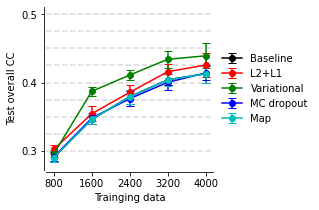

In [20]:
train_nums=[2, 4, 6, 8, len(train_loader)] #len(train_loader)
templabels= [str(ii*batch_size) for ii in train_nums]#['800','1600']  
fig,ax=plt.subplots(nrows=1, ncols=1,figsize=(3,3))
#ax.axhline(y=0.84,color='k',linestyle=':') #upper bound
ax.errorbar(np.arange(len(train_nums)),test_losses_CNN_noregu_mean,yerr=test_losses_CNN_noregu_std,\
            marker='o', color='k',linestyle='-',label='Baseline',alpha=1, capsize=4)
ax.errorbar(np.arange(len(train_nums)),test_losses_CNN_mean,yerr=test_losses_CNN_std,\
            marker='o', color='r',linestyle='-',label='L2+L1',alpha=1, capsize=4)
ax.errorbar(np.arange(len(train_nums)),test_losses_VCNN_mean,yerr=test_losses_VCNN_std,\
            marker='o', color='g',linestyle='-',label='Variational',alpha=1, capsize=4)
ax.errorbar(np.arange(len(train_nums)),test_losses_CNN_dropout_mean,yerr=test_losses_CNN_dropout_std,\
            marker='o', color='b',linestyle='-',label='MC dropout',alpha=1, capsize=4)

ax.errorbar(np.arange(len(train_nums)),test_losses_CNN_map_sigma1_mean,yerr=test_losses_CNN_map_sigma1_std,\
            marker='o', color='c',linestyle='-',label='Map',alpha=1, capsize=4)

# ax.errorbar(np.arange(len(train_nums)),test_losses_CNN_map_mean,yerr=test_losses_CNN_map_std,\
#             marker='o', color='c',linestyle='-',label='CNN map',alpha=1, capsize=4)

ax.set_xticks(np.arange(len(train_nums)).tolist())
ax.set_yticks([0.3,0.4,0.5])
#ax.set_ylim(ymin=0.5)
ax.set_xticklabels(templabels)
#ax.set_ylim(ymin=0.3,ymax=0.5)

y_positions = np.arange(0.3,0.525,0.025)
for y in y_positions:
    ax.axhline(y=y, color='gray', linestyle='--', alpha=0.3)
    
    
ax.set_xlabel('Trainging data')
ax.set_ylabel('Test overall CC')
ax.legend(loc='best')
adjust_spines(ax, ['left', 'bottom'])
handles, labels = ax.get_legend_handles_labels()
lgd = ax.legend(handles, labels, loc='center left',frameon=False, bbox_to_anchor=(1, 0.5))
#fig.savefig('out_result_20220423/Predictive_performance_against_trainingSize_allSeeds_testCC_CNN_map.svg',bbox_extra_artists=(lgd,), bbox_inches='tight')

##### for likelihood and RSME

In [25]:
tempmodel= VanillaCNN()
seeds=np.arange(1,11)
encodeds_CNN = np.zeros([5,len(seeds),test_loader[1].shape[0],test_loader[1].shape[1]])
for i in range(5):
    for j in range(len(seeds)):
        tempmodel.load_state_dict(torch.load('./out_2YQ_Franke2021/'+ tempmodel.__class__.__name__ +\
            'noregu__trainnum_' + str(i)+ '_Franke2021Data_trainN_'  + '_seed_' + str(j) + '.pth'))
        torch.manual_seed(seeds[j])    # reproducible
        torch.cuda.manual_seed(seeds[j])
        encodeds_CNN[i,j],_ = model_predict(tempmodel,test_loader,device,sample_num=100)
#np.save('out_20220423/ensemble_Modelcalibration_encodeds_10seeds_CNN_no_regu.npy',encodeds_CNN)

In [23]:
tempmodel= VanillaCNN()
seeds=np.arange(1,11)
encodeds_CNN = np.zeros([5,len(seeds),test_loader[1].shape[0],test_loader[1].shape[1]])
for i in range(5):
    for j in range(len(seeds)):
        tempmodel.load_state_dict(torch.load('./out_2YQ_Franke2021/'+'VanillaCNN_trainnum_'+str(i)+'_Franke2021Data_trainN__seed_'+str(j)+'.pth'))
        torch.manual_seed(seeds[j])    # reproducible
        torch.cuda.manual_seed(seeds[j])
        encodeds_CNN[i,j],_ = model_predict(tempmodel,test_loader,device,sample_num=100)
#np.save('out_20220423/ensemble_Modelcalibration_encodeds_10seeds_CNN.npy',encodeds_CNN)

In [26]:
tempmodels= ['VariationalCNN']
model_parameters = {'PI': 0.5, 'SIGMA_1': 1, 'SIGMA_2': 0.00247875}
tempmodel = globals()[tempmodels[0]](**model_parameters)
seeds=np.arange(1,11)
encodeds_VCNN = np.zeros([5,len(seeds),101,test_loader[1].shape[0],test_loader[1].shape[1]])
#encodeds_groundtruth = np.zeros([len(seeds),test_loader[1].shape[0],test_loader[1].shape[1]])
for i in range(5):
    for j in range(len(seeds)):
        tempmodel.load_state_dict(torch.load('./out_2YQ_Franke2021/'+'VariationalCNN_trainnum_'+str(i)+'_Franke2021Data_trainN__seed_'+str(j)+'.pth'))
        torch.manual_seed(seeds[j])    # reproducible
        torch.cuda.manual_seed(seeds[j])
        encodeds_VCNN[i,j],_= model_predict(tempmodel,test_loader,device,sample_num=100)
#np.save('out_20220423/ensemble_Modelcalibration_encodeds_10seeds_VCNN.npy',encodeds_VCNN)

In [28]:
tempmodels= ['VanillaCNN_Dropout']
model_parameters = {'p': 0.1}
tempmodel = globals()[tempmodels[0]](**model_parameters)
seeds=np.arange(1,11)
encodeds_CNN_dropout = np.zeros([5,len(seeds),100,test_loader[1].shape[0],test_loader[1].shape[1]])
for i in range(5):
    for j in range(len(seeds)):
        tempmodel.load_state_dict(torch.load('./out_2YQ_Franke2021/' + 'VanillaCNN_Dropout_trainnum_'+str(i)+'_Franke2021Data_trainN__seed_' + str(j) +'.pth'))
        torch.manual_seed(seeds[j])    # reproducible
        torch.cuda.manual_seed(seeds[j])
        encodeds_CNN_dropout[i,j],_= model_predict_dropout(tempmodel,test_loader,device,drop_out_num=100)
#np.save('out_20220423/ensemble_Modelcalibration_encodeds_10seeds_CNN_dropout.npy', encodeds_CNN_dropout)

In [32]:
tempmodels= ['VanillaCNN_MAP']
model_parameters = {'PI': 0.5, 'SIGMA_1':1 , 'SIGMA_2': 1}
tempmodel = globals()[tempmodels[0]](**model_parameters)
seeds=np.arange(1,11)
encodeds_CNN_map = np.zeros([5,len(seeds),test_loader[1].shape[0],test_loader[1].shape[1]])
encodeds_groundtruth = np.zeros([5,len(seeds),test_loader[1].shape[0],test_loader[1].shape[1]])
for i in range(5):
    for j in range(len(seeds)):
        tempmodel.load_state_dict(torch.load('./out_2YQ_Franke2021/'+ tempmodel.__class__.__name__ +\
           '_map_trainnum_' + str(i) + '_Franke2021Data_trainN_'  + '_seed_' + str(j) + '.pth'))
        torch.manual_seed(seeds[j])    # reproducible
        torch.cuda.manual_seed(seeds[j])
        encodeds_CNN_map[i,j],_= model_predict_map(tempmodel,test_loader,device,sample_num=100)
#np.save('out_20220423/ensemble_Modelcalibration_encodeds_10seeds_CNN_MAP.npy',encodeds_CNN_map)

##### RSME

In [35]:
encodeds_CNN_noregu=np.load('out_20220423/ensemble_Modelcalibration_encodeds_10seeds_CNN_no_regu.npy')
encodeds_CNN=np.load( 'out_20220423/ensemble_Modelcalibration_encodeds_10seeds_CNN.npy')
encodeds_VCNN=np.load('out_20220423/ensemble_Modelcalibration_encodeds_10seeds_VCNN.npy')
encodeds_CNN_dropout=np.load('out_20220423/ensemble_Modelcalibration_encodeds_10seeds_CNN_dropout.npy')
encodeds_groundtruth=np.copy(test_set)
encodeds_CNN_map=np.load('out_20220423/ensemble_Modelcalibration_encodeds_10seeds_CNN_MAP.npy')
print (f'encodeds_CNN_noregu.shape: {encodeds_CNN_noregu.shape}')
print (f'encodeds_CNN.shape: {encodeds_CNN.shape}')
print (f'encodeds_VCNN.shape: {encodeds_VCNN.shape}')
print (f'encodeds_CNN_dropout.shape: {encodeds_CNN_dropout.shape}')
print (f'encodeds_CNN_map.shape: {encodeds_CNN_map.shape}')
print (f'encodeds_groundtruth.shape: {encodeds_groundtruth.shape}')

encodeds_VCNN_mean=np.mean(encodeds_VCNN[:,:,0:100],axis=2)
encodeds_CNN_dropout_mean=np.mean(encodeds_CNN_dropout[:,:,0:100],axis=2)
print(f'encodeds_VCNN_mean.shape: {encodeds_VCNN_mean.shape}')
print(f'encodeds_CNN_dropout_mean.shape: {encodeds_CNN_dropout_mean.shape}')

encodeds_CNN_noregu.shape: (5, 10, 79, 161)
encodeds_CNN.shape: (5, 10, 79, 161)
encodeds_VCNN.shape: (5, 10, 101, 79, 161)
encodeds_CNN_dropout.shape: (5, 10, 100, 79, 161)
encodeds_CNN_map.shape: (5, 10, 79, 161)
encodeds_groundtruth.shape: (79, 161)
encodeds_VCNN_mean.shape: (5, 10, 79, 161)
encodeds_CNN_dropout_mean.shape: (5, 10, 79, 161)


In [36]:
testcc_CNN_noregu=np.zeros([5,10])
for i in range(testcc_CNN_noregu.shape[0]):
    for j in range(10):
        testcc_CNN_noregu[i,j]=np.sqrt(np.mean((encodeds_CNN_noregu[i,j].flatten() - encodeds_groundtruth.flatten())**2))
        
testcc_CNN=np.zeros_like((testcc_CNN_noregu))
for i in range(testcc_CNN_noregu.shape[0]):
    for j in range(10):
        testcc_CNN[i,j]=np.sqrt(np.mean((encodeds_CNN[i,j].flatten() - encodeds_groundtruth.flatten())**2))
        
testcc_VCNN=np.zeros_like((testcc_CNN_noregu))
for i in range(testcc_CNN_noregu.shape[0]):
    for j in range(10):
        testcc_VCNN[i,j]=np.sqrt(np.mean((encodeds_VCNN_mean[i,j].flatten() - encodeds_groundtruth.flatten())**2))
        
testcc_CNN_dropout=np.zeros_like((testcc_CNN_noregu))
for i in range(testcc_CNN_noregu.shape[0]):
    for j in range(10):
        testcc_CNN_dropout[i,j]=np.sqrt(np.mean((encodeds_CNN_dropout_mean[i,j].flatten() - encodeds_groundtruth.flatten())**2))
        
testcc_CNN_map=np.zeros_like((testcc_CNN_noregu))
for i in range(testcc_CNN_noregu.shape[0]):
    for j in range(10):
        testcc_CNN_map[i,j]=np.sqrt(np.mean((encodeds_CNN_map[i,j].flatten() - encodeds_groundtruth.flatten())**2))


testcc_CNN_noregu_mean=np.mean(testcc_CNN_noregu,axis=1)
testcc_CNN_noregu_std =np.std (testcc_CNN_noregu,axis=1,ddof=1)
testcc_CNN_mean=np.mean(testcc_CNN,axis=1)
testcc_CNN_std=np.std(testcc_CNN,axis=1,ddof=1)
testcc_VCNN_mean=np.mean(testcc_VCNN,axis=1)
testcc_VCNN_std=np.std(testcc_VCNN,axis=1,ddof=1)
testcc_CNN_dropout_mean=np.mean(testcc_CNN_dropout,axis=1)
testcc_CNN_dropout_std=np.std(testcc_CNN_dropout,axis=1,ddof=1)
testcc_CNN_map_mean=np.mean(testcc_CNN_map,axis=1)
testcc_CNN_map_std=np.std(testcc_CNN_map,axis=1,ddof=1)

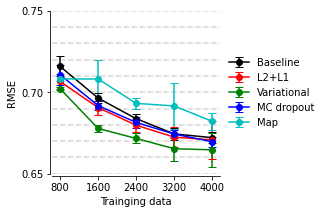

In [37]:
train_nums=[2, 4, 6, 8, len(train_loader)] #len(train_loader)
templabels= [str(ii*batch_size) for ii in train_nums]#['800','1600']  
fig,ax=plt.subplots(nrows=1, ncols=1,figsize=(3,3))
#ax.axhline(y=0.84,color='k',linestyle=':') #upper bound
ax.errorbar(np.arange(len(train_nums)),testcc_CNN_noregu_mean,yerr=testcc_CNN_noregu_std,\
            marker='o', color='k',linestyle='-',label='Baseline',alpha=1, capsize=4)
ax.errorbar(np.arange(len(train_nums)),testcc_CNN_mean,yerr=testcc_CNN_std,\
            marker='o', color='r',linestyle='-',label='L2+L1',alpha=1, capsize=4)
ax.errorbar(np.arange(len(train_nums)),testcc_VCNN_mean,yerr=testcc_VCNN_std,\
            marker='o', color='g',linestyle='-',label='Variational',alpha=1, capsize=4)
ax.errorbar(np.arange(len(train_nums)),testcc_CNN_dropout_mean,yerr=testcc_CNN_dropout_std,\
            marker='o', color='b',linestyle='-',label='MC dropout',alpha=1, capsize=4)

ax.errorbar(np.arange(len(train_nums)),testcc_CNN_map_mean,yerr=testcc_CNN_map_std,\
            marker='o', color='c',linestyle='-',label='Map',alpha=1, capsize=4)

# ax.errorbar(np.arange(len(train_nums)),test_losses_CNN_map_mean,yerr=test_losses_CNN_map_std,\
#             marker='o', color='c',linestyle='-',label='CNN map',alpha=1, capsize=4)

ax.set_xticks(np.arange(len(train_nums)).tolist())
ax.set_xticklabels(templabels)
ax.set_yticks([0.65,0.7,0.75])
ax.set_ylim(ymin=0.65,ymax=0.75)
y_positions = np.arange(0.65,0.80,0.01)
for y in y_positions:
    ax.axhline(y=y, color='gray', linestyle='--', alpha=0.3)
    
ax.set_xlabel('Trainging data')
ax.set_ylabel('RMSE')
ax.legend(loc='best')
adjust_spines(ax, ['left', 'bottom'])
handles, labels = ax.get_legend_handles_labels()
lgd = ax.legend(handles, labels, loc='center left',frameon=False, bbox_to_anchor=(1, 0.5))
# fig.savefig('out_result_20220423/Predictive_performance_against_trainingSize_allSeeds_rmse_CNN_map.svg',bbox_extra_artists=(lgd,), bbox_inches='tight')

In [25]:
#permutation test
#https://stackoverflow.com/questions/24795535/pythons-implementation-of-permutation-test-with-permutation-number-as-input
#permutation test using monte-carlo method
def perm_test(xs, ys, nmc, randomseed):
    n, k = len(xs), 0
    diff = np.abs(np.mean(xs) - np.mean(ys))
    zs = np.concatenate([xs, ys])
    for j in range(nmc):
        np.random.seed(randomseed+j)
        np.random.shuffle(zs)
        k += diff < np.abs(np.mean(zs[:n]) - np.mean(zs[n:]))
    return k / nmc
def perm_test_group(list_of_array,nmc=10000,randomseed=66):
    perm_res=[]
    for ii in np.arange(len(list_of_array)):
        for jj in np.arange(ii+1,len(list_of_array)):
            temp=perm_test(list_of_array[ii], list_of_array[jj], nmc, (ii*jj+jj+randomseed)*nmc)
            perm_res.append(temp)
    return perm_res
#
print (f'VCNN vs. L2+L1')
print('800 training data\n')
print ('L2+L1: ', perm_test(testcc_VCNN[0],testcc_CNN[0],nmc=10000,randomseed=66))
print('\n1600 training data\n')
print ('L2+L1: ', perm_test(testcc_VCNN[1],testcc_CNN[1],nmc=10000,randomseed=66))
print('\n2400 training data\n')
print ('L2+L1: ', perm_test(testcc_VCNN[2],testcc_CNN[2],nmc=10000,randomseed=66))
print('\n3200 training data\n')
print ('L2+L1: ', perm_test(testcc_VCNN[3],testcc_CNN[3],nmc=10000,randomseed=66))
print('\n4000 training data\n')
print ('L2+L1: ', perm_test(testcc_VCNN[4],testcc_CNN[4],nmc=10000,randomseed=66))
print (f'VCNN vs. MC dropout')
print('800 training data\n')
print ('L2+L1: ', perm_test(testcc_VCNN[0],testcc_CNN_dropout[0],nmc=10000,randomseed=66))
print('\n1600 training data\n')
print ('L2+L1: ', perm_test(testcc_VCNN[1],testcc_CNN_dropout[1],nmc=10000,randomseed=66))
print('\n2400 training data\n')
print ('L2+L1: ', perm_test(testcc_VCNN[2],testcc_CNN_dropout[2],nmc=10000,randomseed=66))
print('\n3200 training data\n')
print ('L2+L1: ', perm_test(testcc_VCNN[3],testcc_CNN_dropout[3],nmc=10000,randomseed=66))
print('\n4000 training data\n')
print ('L2+L1: ', perm_test(testcc_VCNN[4],testcc_CNN_dropout[4],nmc=10000,randomseed=66))

VCNN vs. L2+L1
800 training data

L2+L1:  0.0024

1600 training data

L2+L1:  0.0

2400 training data

L2+L1:  0.0001

3200 training data

L2+L1:  0.0316

4000 training data

L2+L1:  0.2351
VCNN vs. MC dropout
800 training data

L2+L1:  0.0001

1600 training data

L2+L1:  0.0

2400 training data

L2+L1:  0.0001

3200 training data

L2+L1:  0.0021

4000 training data

L2+L1:  0.1709


##### Log-likelihood

In [ ]:
encodeds_CNN_noregu=np.load('out_20220423/ensemble_Modelcalibration_encodeds_10seeds_CNN_no_regu.npy')
encodeds_CNN=np.load( 'out_20220423/ensemble_Modelcalibration_encodeds_10seeds_CNN.npy')
encodeds_VCNN=np.load('out_20220423/ensemble_Modelcalibration_encodeds_10seeds_VCNN.npy')
encodeds_CNN_dropout=np.load('out_20220423/ensemble_Modelcalibration_encodeds_10seeds_CNN_dropout.npy')
encodeds_groundtruth=np.copy(test_set)
encodeds_CNN_map=np.load('out_20220423/ensemble_Modelcalibration_encodeds_10seeds_CNN_MAP.npy')
print (f'encodeds_CNN_noregu.shape: {encodeds_CNN_noregu.shape}')
print (f'encodeds_CNN.shape: {encodeds_CNN.shape}')
print (f'encodeds_VCNN.shape: {encodeds_VCNN.shape}')
print (f'encodeds_CNN_dropout.shape: {encodeds_CNN_dropout.shape}')
print (f'encodeds_CNN_map.shape: {encodeds_CNN_map.shape}')
print (f'encodeds_groundtruth.shape: {encodeds_groundtruth.shape}')

encodeds_VCNN_mean=np.mean(encodeds_VCNN[:,:,0:100],axis=2)
encodeds_CNN_dropout_mean=np.mean(encodeds_CNN_dropout[:,:,0:100],axis=2)
print(f'encodeds_VCNN_mean.shape: {encodeds_VCNN_mean.shape}')
print(f'encodeds_CNN_dropout_mean.shape: {encodeds_CNN_dropout_mean.shape}')

In [27]:
testcc_CNN_noregu=np.zeros([5,10])
for i in range(testcc_CNN_noregu.shape[0]):
    for j in range(10):
        testcc_CNN_noregu[i,j]=-nn.functional.poisson_nll_loss(torch.from_numpy(encodeds_CNN_noregu[i,j]), \
                                       torch.from_numpy(encodeds_groundtruth), log_input=False).detach().numpy()
        
testcc_CNN=np.zeros_like((testcc_CNN_noregu))
for i in range(testcc_CNN_noregu.shape[0]):
    for j in range(10):
        testcc_CNN[i,j]=-nn.functional.poisson_nll_loss(torch.from_numpy(encodeds_CNN[i,j]), \
                                       torch.from_numpy(encodeds_groundtruth), log_input=False).detach().numpy()
        
testcc_VCNN=np.zeros_like((testcc_CNN_noregu))
for i in range(testcc_CNN_noregu.shape[0]):
    for j in range(10):
        testcc_VCNN[i,j]=-nn.functional.poisson_nll_loss(torch.from_numpy(encodeds_VCNN_mean[i,j]), \
                                       torch.from_numpy(encodeds_groundtruth), log_input=False).detach().numpy()
        
testcc_CNN_dropout=np.zeros_like((testcc_CNN_noregu))
for i in range(testcc_CNN_noregu.shape[0]):
    for j in range(10):
        testcc_CNN_dropout[i,j]=-nn.functional.poisson_nll_loss(torch.from_numpy(encodeds_CNN_dropout_mean[i,j]), \
                                       torch.from_numpy(encodeds_groundtruth), log_input=False).detach().numpy()
        
testcc_CNN_map=np.zeros_like((testcc_CNN_noregu))
for i in range(testcc_CNN_noregu.shape[0]):
    for j in range(10):
        testcc_CNN_map[i,j]=-nn.functional.poisson_nll_loss(torch.from_numpy(encodeds_CNN_map[i,j]), \
                                       torch.from_numpy(encodeds_groundtruth), log_input=False).detach().numpy()


testcc_CNN_noregu_mean=np.mean(testcc_CNN_noregu,axis=1)
testcc_CNN_noregu_std =np.std (testcc_CNN_noregu,axis=1,ddof=1)
testcc_CNN_mean=np.mean(testcc_CNN,axis=1)
testcc_CNN_std=np.std(testcc_CNN,axis=1,ddof=1)
testcc_VCNN_mean=np.mean(testcc_VCNN,axis=1)
testcc_VCNN_std=np.std(testcc_VCNN,axis=1,ddof=1)
testcc_CNN_dropout_mean=np.mean(testcc_CNN_dropout,axis=1)
testcc_CNN_dropout_std=np.std(testcc_CNN_dropout,axis=1,ddof=1)
testcc_CNN_map_mean=np.mean(testcc_CNN_map,axis=1)
testcc_CNN_map_std=np.std(testcc_CNN_map,axis=1,ddof=1)

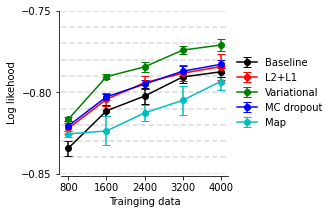

In [34]:
train_nums=[2, 4, 6, 8, len(train_loader)] #len(train_loader)
templabels= [str(ii*batch_size) for ii in train_nums]#['800','1600']  
fig,ax=plt.subplots(nrows=1, ncols=1,figsize=(3,3))
#ax.axhline(y=0.84,color='k',linestyle=':') #upper bound
ax.errorbar(np.arange(len(train_nums)),testcc_CNN_noregu_mean,yerr=testcc_CNN_noregu_std,\
            marker='o', color='k',linestyle='-',label='Baseline',alpha=1, capsize=4)
ax.errorbar(np.arange(len(train_nums)),testcc_CNN_mean,yerr=testcc_CNN_std,\
            marker='o', color='r',linestyle='-',label='L2+L1',alpha=1, capsize=4)
ax.errorbar(np.arange(len(train_nums)),testcc_VCNN_mean,yerr=testcc_VCNN_std,\
            marker='o', color='g',linestyle='-',label='Variational',alpha=1, capsize=4)
ax.errorbar(np.arange(len(train_nums)),testcc_CNN_dropout_mean,yerr=testcc_CNN_dropout_std,\
            marker='o', color='b',linestyle='-',label='MC dropout',alpha=1, capsize=4)

ax.errorbar(np.arange(len(train_nums)),testcc_CNN_map_mean,yerr=testcc_CNN_map_std,\
            marker='o', color='c',linestyle='-',label='Map',alpha=1, capsize=4)

# ax.errorbar(np.arange(len(train_nums)),test_losses_CNN_map_mean,yerr=test_losses_CNN_map_std,\
#             marker='o', color='c',linestyle='-',label='CNN map',alpha=1, capsize=4)

ax.set_xticks(np.arange(len(train_nums)).tolist())
ax.set_xticklabels(templabels)
ax.set_yticks([-0.85,-0.8,-0.75])
ax.set_ylim(ymin=-0.85,ymax=-0.75)
y_positions = np.arange(-0.85,-0.74,0.01)
for y in y_positions:
    ax.axhline(y=y, color='gray', linestyle='--', alpha=0.3)
    
ax.set_xlabel('Trainging data')
ax.set_ylabel('Log likehood')
ax.legend(loc='best')
adjust_spines(ax, ['left', 'bottom'])
handles, labels = ax.get_legend_handles_labels()
lgd = ax.legend(handles, labels, loc='center left',frameon=False, bbox_to_anchor=(1, 0.5))
# fig.savefig('out_result_20220423/Predictive_performance_against_trainingSize_allSeeds_logl_CNN_map.svg',bbox_extra_artists=(lgd,), bbox_inches='tight')

In [33]:
#permutation test
#https://stackoverflow.com/questions/24795535/pythons-implementation-of-permutation-test-with-permutation-number-as-input
#permutation test using monte-carlo method
def perm_test(xs, ys, nmc, randomseed):
    n, k = len(xs), 0
    diff = np.abs(np.mean(xs) - np.mean(ys))
    zs = np.concatenate([xs, ys])
    for j in range(nmc):
        np.random.seed(randomseed+j)
        np.random.shuffle(zs)
        k += diff < np.abs(np.mean(zs[:n]) - np.mean(zs[n:]))
    return k / nmc
def perm_test_group(list_of_array,nmc=10000,randomseed=66):
    perm_res=[]
    for ii in np.arange(len(list_of_array)):
        for jj in np.arange(ii+1,len(list_of_array)):
            temp=perm_test(list_of_array[ii], list_of_array[jj], nmc, (ii*jj+jj+randomseed)*nmc)
            perm_res.append(temp)
    return perm_res
#
print (f'VCNN vs. MC dropout')
print('800 training data\n')
print ('L2+L1: ', perm_test(testcc_VCNN[0],testcc_CNN_dropout[0],nmc=10000,randomseed=66))
print('\n1600 training data\n')
print ('L2+L1: ', perm_test(testcc_VCNN[1],testcc_CNN_dropout[1],nmc=10000,randomseed=66))
print('\n2400 training data\n')
print ('L2+L1: ', perm_test(testcc_VCNN[2],testcc_CNN_dropout[2],nmc=10000,randomseed=66))
print('\n3200 training data\n')
print ('L2+L1: ', perm_test(testcc_VCNN[3],testcc_CNN_dropout[3],nmc=10000,randomseed=66))
print('\n4000 training data\n')
print ('L2+L1: ', perm_test(testcc_VCNN[4],testcc_CNN_dropout[4],nmc=10000,randomseed=66))

VCNN vs. MC dropout
800 training data

L2+L1:  0.0002

1600 training data

L2+L1:  0.0

2400 training data

L2+L1:  0.0

3200 training data

L2+L1:  0.0

4000 training data

L2+L1:  0.0


#### Predictive response with std

In [17]:
Neurons=[95,123]

(79, 161)
(79, 161)


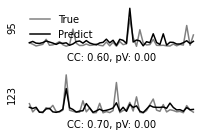

In [46]:
#no regu
tempmodel= VanillaCNN()
tempmodel.load_state_dict(torch.load('./out_2YQ_Franke2021/VanillaCNNnoregu__trainnum_4_Franke2021Data_trainN__seed_0.pth'))
encoded_np,y=model_predict(tempmodel,test_loader,device,sample_num=100) 
print (encoded_np.shape)
print (y.shape)
#
nrows=len(Neurons)
fig,axes=plt.subplots(nrows=nrows,ncols=1,figsize=(3,int(nrows/1)))
for ii in range(nrows):
    testcc,testpvalue=pearsonr(encoded_np[:,Neurons[ii]], y[:,Neurons[ii]])
    axes[ii].plot(y[:50,Neurons[ii]],color='gray',linestyle='-',label='True')
    axes[ii].plot(encoded_np[:50,Neurons[ii]],color='k',linestyle='-',label='Predict')
    axes[ii].spines['left'].set_visible(False)
    axes[ii].spines['bottom'].set_visible(False)
    axes[ii].spines['right'].set_visible(False)
    axes[ii].spines['top'].set_visible(False)
    axes[ii].set_xticks([])
    axes[ii].set_yticks([])
    axes[ii].set_xlabel('CC: %.2f, pV: %.2f' %(testcc,testpvalue))
    axes[ii].set_ylabel('%d' %(Neurons[ii]))
axes[0].legend(loc='best',frameon=False)
plt.tight_layout()
#fig.savefig('out_result_20220423/Predictive_response_CNN_noregu.svg')

(79, 161)
(79, 161)


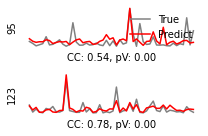

In [18]:
# with regu
tempmodel= VanillaCNN()
tempmodel.load_state_dict(torch.load('./out_2YQ_Franke2021/VanillaCNN_trainnum_4_Franke2021Data_trainN__seed_0.pth'))
encoded_np,y=model_predict(tempmodel,test_loader,device,sample_num=100) 
print (encoded_np.shape)
print (y.shape)
#
nrows=len(Neurons)
fig,axes=plt.subplots(nrows=nrows,ncols=1,figsize=(3,int(nrows/1)))
for ii in range(nrows):
    testcc,testpvalue=pearsonr(encoded_np[:,Neurons[ii]], y[:,Neurons[ii]])
    axes[ii].plot(y[:50,Neurons[ii]],color='gray',linestyle='-',label='True')
    axes[ii].plot(encoded_np[:50,Neurons[ii]],color='r',linestyle='-',label='Predict')
    axes[ii].spines['left'].set_visible(False)
    axes[ii].spines['bottom'].set_visible(False)
    axes[ii].spines['right'].set_visible(False)
    axes[ii].spines['top'].set_visible(False)
    axes[ii].set_xticks([])
    axes[ii].set_yticks([])
    axes[ii].set_xlabel('CC: %.2f, pV: %.2f' %(testcc,testpvalue))
    axes[ii].set_ylabel('%d' %(Neurons[ii]))
axes[0].legend(loc='best',frameon=False)
plt.tight_layout()
#fig.savefig('out_result_20220423/Predictive_response_CNN.svg')

(101, 79, 161)
(79, 161)
(79, 161)


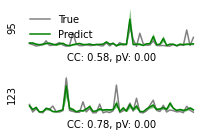

In [55]:
#tempmodel= VariationalCNN()
tempmodels=['VariationalCNN'] 
model_parameters = {'PI': 0.5, 'SIGMA_1': 1, 'SIGMA_2': 0.00247875}
tempmodel = globals()[tempmodels[0]](**model_parameters)
torch.manual_seed(1)    # reproducible
torch.cuda.manual_seed(1)
tempmodel.load_state_dict(torch.load('./out_2YQ_Franke2021/VariationalCNN_trainnum_4_Franke2021Data_trainN__seed_0.pth'))
encoded_np,y=model_predict(tempmodel,test_loader,device,sample_num=100) 
print (encoded_np.shape)
print (y.shape)
encoded_np_std=np.std(encoded_np[:100], axis=0,ddof=1)     #only use sampling numbers 100, not 101
encoded_np    =np.mean(encoded_np[:100],axis=0)
print (encoded_np.shape)
#
nrows=len(Neurons)
fig,axes=plt.subplots(nrows=nrows,ncols=1,figsize=(3,int(nrows/1)))
for ii in range(nrows):
    testcc,testpvalue=pearsonr(encoded_np[:,Neurons[ii]], y[:,Neurons[ii]])
    axes[ii].plot(y[:50,Neurons[ii]],color='gray',linestyle='-',label='True')
    axes[ii].plot(encoded_np[:50,Neurons[ii]],color='g',linestyle='-',label='Predict')
    axes[ii].fill_between(np.arange(50),y1=encoded_np[:50,Neurons[ii]]+encoded_np_std[:50,Neurons[ii]],\
                          y2=encoded_np[:50,Neurons[ii]]-encoded_np_std[:50,Neurons[ii]],color='g',linewidth=0,alpha=0.5)
    axes[ii].spines['left'].set_visible(False)
    axes[ii].spines['bottom'].set_visible(False)
    axes[ii].spines['right'].set_visible(False)
    axes[ii].spines['top'].set_visible(False)
    axes[ii].set_xticks([])
    axes[ii].set_yticks([])
    axes[ii].set_xlabel('CC: %.2f, pV: %.2f' %(testcc,testpvalue))
    axes[ii].set_ylabel('%d' %(Neurons[ii]))
axes[0].legend(loc='best',frameon=False)
plt.tight_layout()
#fig.savefig('out_result_20220423/Predictive_response_VCNN.svg')

(100, 79, 161)
(79, 161)
(79, 161)


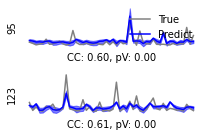

In [35]:
#tempmodel=VanillaCNN_Dropout()
tempmodels=['VanillaCNN_Dropout']
torch.manual_seed(1)    # reproducible
torch.cuda.manual_seed(1)
model_parameters = {'p':0.1 }
tempmodel = globals()[tempmodels[0]](**model_parameters)
tempmodel.load_state_dict(torch.load('./out_2YQ_Franke2021/VanillaCNN_Dropout_trainnum_4_Franke2021Data_trainN__seed_0.pth'))
encoded_np,y=model_predict_dropout(tempmodel,test_loader,device,drop_out_num=100,sample_num=100) 
print (encoded_np.shape)
print (y.shape)
encoded_np_std=np.std(encoded_np, axis=0,ddof=1)
encoded_np    =np.mean(encoded_np,axis=0)
print (encoded_np.shape)

nrows=len(Neurons)
fig,axes=plt.subplots(nrows=nrows,ncols=1,figsize=(3,int(nrows/1)))
for ii in range(nrows):
    testcc,testpvalue=pearsonr(encoded_np[:,Neurons[ii]], y[:,Neurons[ii]])
    axes[ii].plot(y[:50,Neurons[ii]],color='gray',linestyle='-',label='True')
    axes[ii].plot(encoded_np[:50,Neurons[ii]],color='b',linestyle='-',label='Predict')
    axes[ii].fill_between(x=np.arange(50),y1=encoded_np[:50,Neurons[ii]]+encoded_np_std[:50,Neurons[ii]],\
                          y2=encoded_np[:50,Neurons[ii]]-encoded_np_std[:50,Neurons[ii]],color='b',alpha=0.5)
    axes[ii].spines['left'].set_visible(False)
    axes[ii].spines['bottom'].set_visible(False)
    axes[ii].spines['right'].set_visible(False)
    axes[ii].spines['top'].set_visible(False)
    axes[ii].set_xticks([])
    axes[ii].set_yticks([])
    axes[ii].set_xlabel('CC: %.2f, pV: %.2f' %(testcc,testpvalue))
    axes[ii].set_ylabel('%d' %(Neurons[ii]))
axes[0].legend(loc='best',frameon=False)
plt.tight_layout()
#fig.savefig('out_result_20220423/Predictive_response_CNN_MCdropout.svg')